In [4]:
#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt
#import numpy.random as R
import plotly.graph_objs as go
from plotly.subplots import make_subplots

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import (Dense, Conv2D, Conv2DTranspose, MaxPooling2D, Reshape, GlobalMaxPooling2D, InputLayer,
                                    Flatten, BatchNormalization, LeakyReLU, Input, Embedding, Concatenate, Dropout)
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm


In [9]:
data = pd.read_csv("P0013.csv", delimiter=";")
foo = np.array(data.iloc[:, 2:]).reshape(-1)
date = pd.date_range(start=data.iloc[0, 0], end="2022-12-31 23:50:00", freq="10min")

dataframe = pd.DataFrame({"Date":date, "Production":np.concatenate([foo, np.zeros(2)])})
df = dataframe.copy()
df.set_index("Date", inplace=True)
df.head()

Production
Date                           
2020-01-01 00:00:00         0.0
2020-01-01 00:10:00         0.0
2020-01-01 00:20:00         0.0
2020-01-01 00:30:00         0.0
2020-01-01 00:40:00         0.0

In [4]:
images = df.values.reshape(-1, 12, 12, 1)
images.shape

(1096, 12, 12, 1)

In [5]:
df = df.resample("D").mean()
df.head()

Production
Date                  
2020-01-01    9.208333
2020-01-02   10.763889
2020-01-03   17.819444
2020-01-04   47.104167
2020-01-05   43.361111

In [6]:
df.reset_index(inplace=True)
df.head()

Date  Production
0 2020-01-01    9.208333
1 2020-01-02   10.763889
2 2020-01-03   17.819444
3 2020-01-04   47.104167
4 2020-01-05   43.361111

In [7]:
# Fonction pour déterminer la saison
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 0
    elif month in [3, 4, 5]:
        return 1
    elif month in [6, 7, 8]:
        return 2
    elif month in [9, 10, 11]:
        return 3

# Appliquer la fonction au DataFrame
df['labels'] = df["Date"].apply(get_season)

# Afficher le DataFrame avec la colonne des saisons
df.head()

Date  Production  labels
0 2020-01-01    9.208333       0
1 2020-01-02   10.763889       0
2 2020-01-03   17.819444       0
3 2020-01-04   47.104167       0
4 2020-01-05   43.361111       0

In [10]:
a = dataframe[(dataframe.index > '2020-06-08') & (dataframe.index < '2020-06-20')].rolling(2).mean()
a.fillna(0, inplace=True)
dataframe[(dataframe.index > '2020-06-21') & (dataframe.index < '2020-07-03')] = a.values

<Axes: xlabel='Date'>

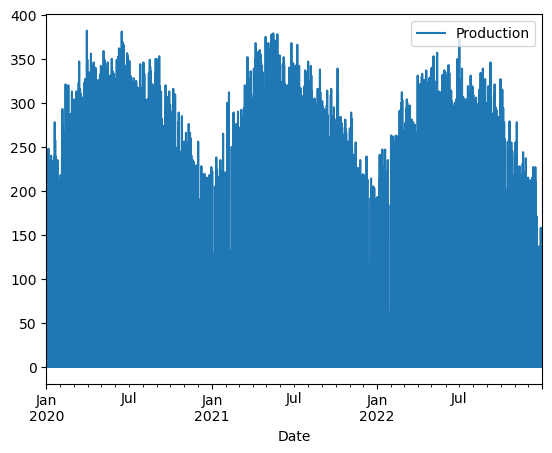

In [11]:
dataframe.plot()

In [12]:
images.shape, label.shape

((1096, 12, 12, 1), (1096,))

In [13]:
images = images / 382.0
images.max(), images.min()

(1.0, 0.0)

### Model generator

In [15]:
# import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from keras.preprocessing import image
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

In [16]:
batch_size = 1
epoch_count = 50
noise_dim = 100
n_class = 4
tags = ['Hiver', 'Printemps', 'Ete', 'Automne']
img_size = 12

dataset = tf.data.Dataset.from_tensor_slices((images, label[:1096]))
dataset = dataset.shuffle(buffer_size=1096).batch(batch_size)

In [17]:
# Defnie Loss function for classification between Real and Fake
bce_loss = tf.keras.losses.BinaryCrossentropy()

# Discriminator Loss
def discriminator_loss(real, fake):
  real_loss = bce_loss(tf.ones_like(real), real)
  fake_loss = bce_loss(tf.zeros_like(fake), fake)
  total_loss = real_loss + fake_loss
  return total_loss

# Generator Loss
def generator_loss(preds):
  return bce_loss(tf.ones_like(preds), preds)

d_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
g_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

In [18]:
def build_generator():

  # Label input
  in_label = tf.keras.layers.Input(shape=(1, ))

  # Create an embedding layer for all the 10 classes in the form of a vector of size 50
  li = tf.keras.layers.Embedding(n_class, 50)(in_label)

  n_nodes = 3*3
  li = tf.keras.layers.Dense(n_nodes)(li)
  # Reshape the layer
  li = tf.keras.layers.Reshape((3, 3, 1))(li)

  # image generator input
  in_lat = tf.keras.layers.Input(shape=(noise_dim, ))

  n_nodes = 256*3*3
  gen = tf.keras.layers.Dense(n_nodes)(in_lat)
  gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)
  gen = tf.keras.layers.Reshape((3, 3, 256))(gen)

  merge = tf.keras.layers.Concatenate()([gen, li])

  gen = tf.keras.layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding="same")(merge)
  gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)

  gen = tf.keras.layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding="same")(gen)
  gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)

  gen = tf.keras.layers.Conv2DTranspose(256, (4, 4), strides=(1, 1), padding="same")(gen)
  gen = tf.keras.layers.LeakyReLU(alpha=0.2)(gen)

  out_layer = tf.keras.layers.Conv2D(1, (3, 3), activation='relu', padding='same')(gen)
  model = Model(inputs=[in_lat, in_label], outputs=out_layer)
  return model

g_model = build_generator()
g_model.summary()

C:\Users\saida\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2304)      │    232,704 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 50)     │        200 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 2304)      │          0 │ dense_1[0][0]     │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 9)      │        459 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 3, 3, 256) │          0 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 3, 3, 1)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 3, 3, 257) │          0 │ reshape_1[0][0],  │
│ (Concatenate)       │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 6, 6, 256) │  1,052,928 │ concatenate[0][0] │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 6, 6, 256) │          0 │ conv2d_transpose… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 12, 12,    │  1,048,832 │ leaky_re_lu_1[0]… │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 12, 12,    │          0 │ conv2d_transpose… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 12, 12,    │  1,048,832 │ leaky_re_lu_2[0]… │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 12, 12,    │          0 │ conv2d_transpose… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 12, 12, 1) │      2,305 │ leaky_re_lu_3[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,386,260 (12.92 MB)

 Trainable params: 3,386,260 (12.92 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
def build_discriminator():

  # label input
  in_label = tf.keras.layers.Input(shape=(1,))
  # This vector of size 50 will be learnt by the discriminator
  li = tf.keras.layers.Embedding(n_class, 50)(in_label)

  n_nodes = img_size*img_size
  li = tf.keras.layers.Dense(n_nodes)(li)
  li = tf.keras.layers.Reshape((img_size, img_size, 1))(li)

  # image input
  in_image = tf.keras.layers.Input(shape=(img_size, img_size, 1))
  merge = tf.keras.layers.Concatenate()([in_image, li])

  # We will combine input label with input image and supply as inputs to the model.
  fe = tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same")(merge)
  fe = tf.keras.layers.LeakyReLU(alpha=0.2)(fe)

  fe = tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same")(fe)
  fe = tf.keras.layers.LeakyReLU(alpha=0.2)(fe)

  fe = tf.keras.layers.Conv2D(256, (3, 3), padding="same")(fe)
  fe = tf.keras.layers.LeakyReLU(alpha=0.2)(fe)
    
  fe = tf.keras.layers.Flatten()(fe)
  fe = tf.keras.layers.Dropout(0.4)(fe)

  out_layer = tf.keras.layers.Dense(1, activation="sigmoid")(fe)

  # define model the model
  model = Model(inputs=[in_image, in_label], outputs=out_layer)
  return model

d_model = build_discriminator()
d_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 50)     │        200 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1, 144)    │      7,344 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 12, 12, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 12, 12, 1) │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 12, 12, 2) │          0 │ input_layer_3[0]… │
│ (Concatenate)       │                   │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 6, 6, 256) │      4,864 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_4       │ (None, 6, 6, 256) │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 3, 3, 256) │    590,080 │ leaky_re_lu_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 3, 3, 256) │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 3, 3, 256) │    590,080 │ leaky_re_lu_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 3, 3, 256) │          0 │ conv2d_3[0][0]    │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2304)      │          0 │ leaky_re_lu_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2304)      │          0 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      2,305 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,194,873 (4.56 MB)

 Trainable params: 1,194,873 (4.56 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Compiles the train_step function into a callable Tensorflow graph
@tf.function
def train_step(dataset):

  real_images, real_labels = dataset

  
  # Sample random points in the latent space and concatenate the labels.
  random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim))
  generated_images = g_model([random_latent_vectors, real_labels])

  # Train the discriminator.
  with tf.GradientTape() as tape:
    pred_fake = d_model([generated_images, real_labels])
    pred_real = d_model([real_images, real_labels])

    d_loss = discriminator_loss(pred_real, pred_fake)

  grads = tape.gradient(d_loss, d_model.trainable_variables)
  # print(grads)
  d_optimizer.apply_gradients(zip(grads, d_model.trainable_variables))


  #-------------------------------------------------------------------

  # Sample random points in the latent space
  random_latent_vectors = tf.random.normal(shape=(batch_size, noise_dim))

  # Train the generator
  with tf.GradientTape() as tape:
    fake_images = g_model([random_latent_vectors, real_labels])
    predictions = d_model([fake_images, real_labels])
    g_loss = generator_loss(predictions)

  grads = tape.gradient(g_loss, g_model.trainable_variables)
  g_optimizer.apply_gradients(zip(grads, g_model.trainable_variables))

  return d_loss, g_loss

In [21]:
# Helper function to plot generated images
def show_samples(num_samples, n_class, g_model):

  fig, axes = plt.subplots(4, num_samples, figsize=(10, 10))
  fig.tight_layout()
  fig.subplots_adjust(wspace=None, hspace=0.2)

  for l in np.arange(4):
    random_noise = tf.random.normal(shape=(num_samples, noise_dim))
    label = tf.ones(num_samples)*l
    gen_imgs = g_model.predict([random_noise, label])
    for j in range(gen_imgs.shape[0]):
      img = image.array_to_img(gen_imgs[j], scale=True)
      axes[l, j].imshow(img)
      axes[l, j].yaxis.set_ticks([])
      axes[l, j].xaxis.set_ticks([])

      if j == 0:
        axes[l, j].set_ylabel(tags[l])
  plt.show()

100%|██████████| 1096/1096 [00:45<00:00, 24.22it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

C:\Users\saida\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_4', 'keras_tensor']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


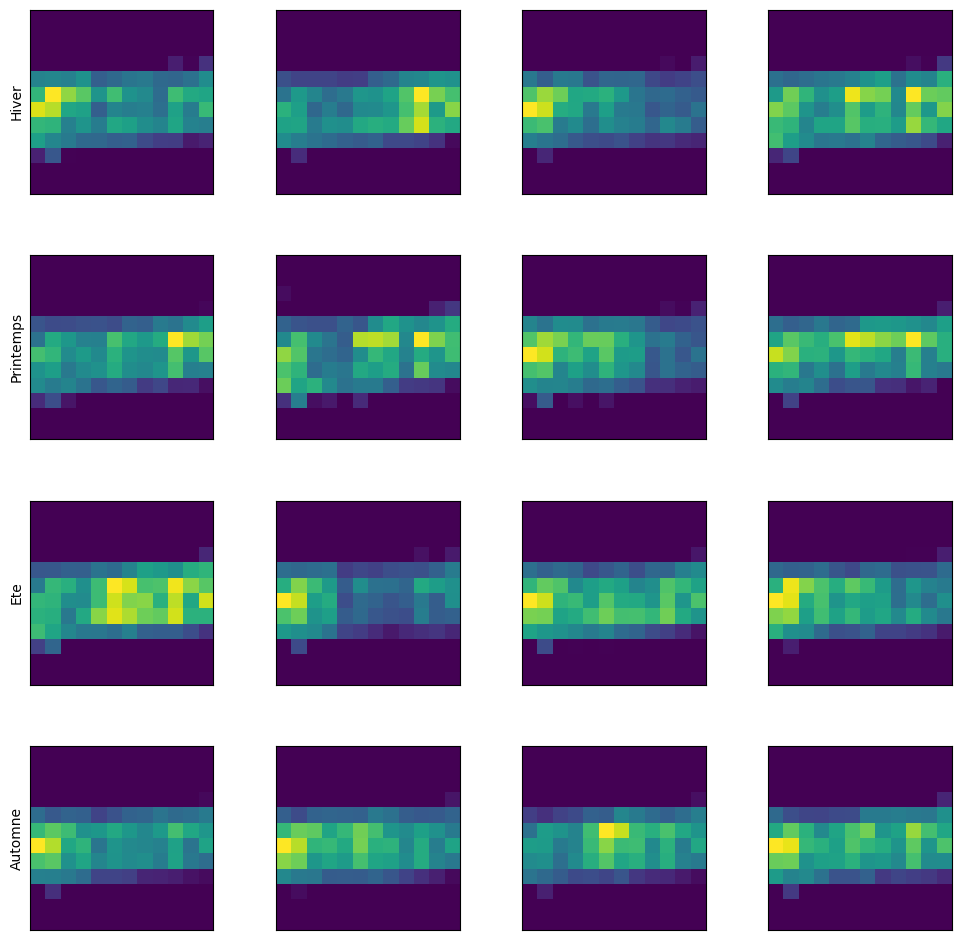

Epoch: 0 -- Generator Loss: 1.532707929611206, Discriminator Loss: 1.1432849168777466

Took 46.12086224555969 seconds. 




100%|██████████| 1096/1096 [00:42<00:00, 25.76it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


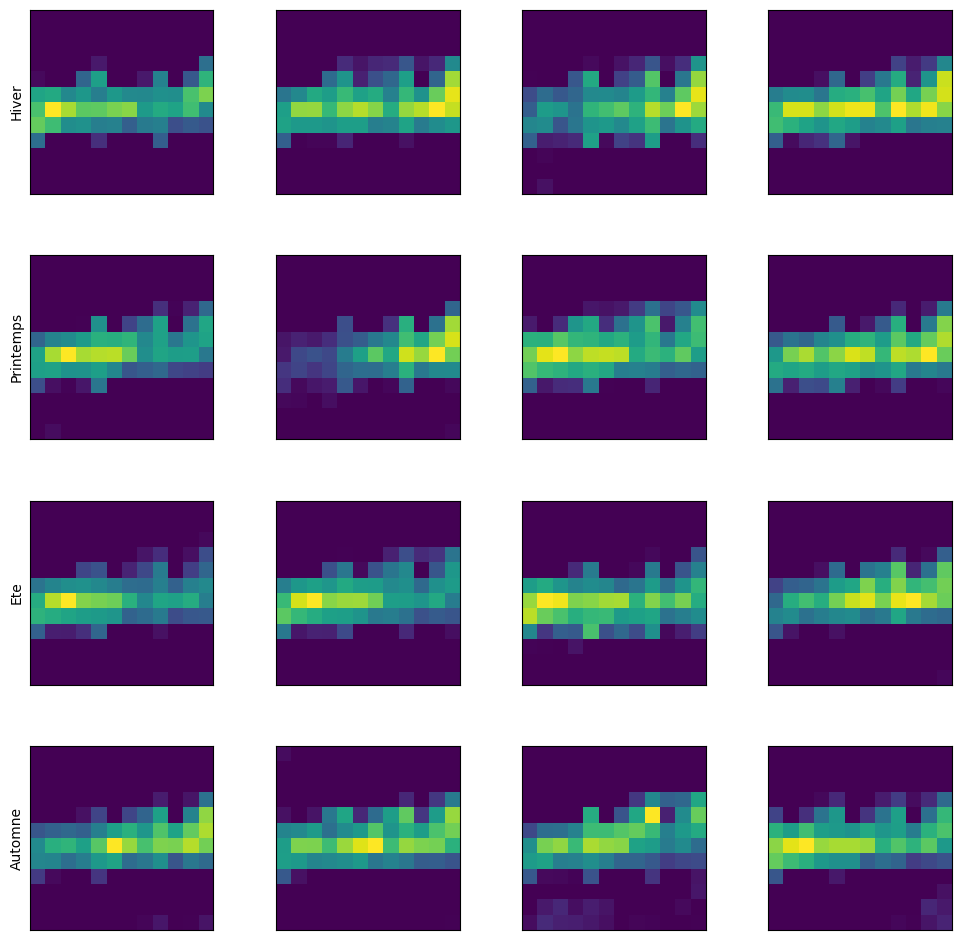

Epoch: 1 -- Generator Loss: 0.7655741572380066, Discriminator Loss: 1.349868893623352

Took 43.34887170791626 seconds. 




100%|██████████| 1096/1096 [00:42<00:00, 25.60it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


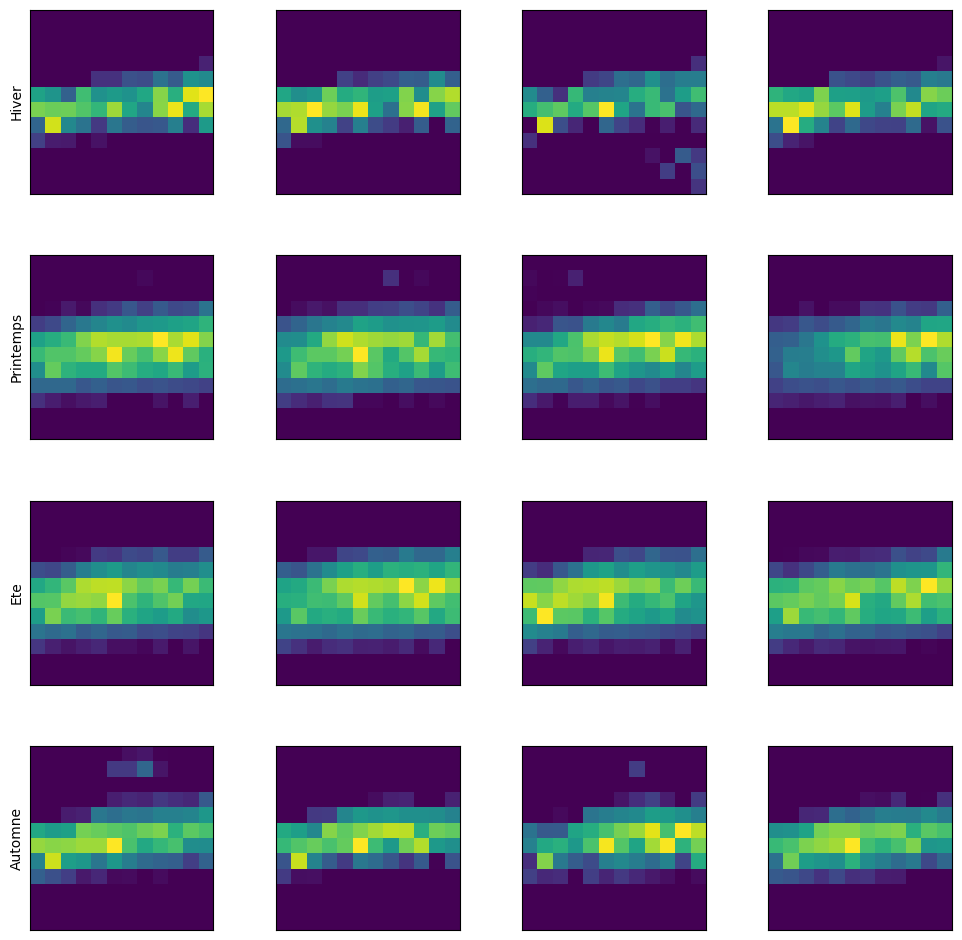

Epoch: 2 -- Generator Loss: 0.7498236894607544, Discriminator Loss: 1.3690725564956665

Took 43.925652265548706 seconds. 




100%|██████████| 1096/1096 [00:42<00:00, 25.63it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


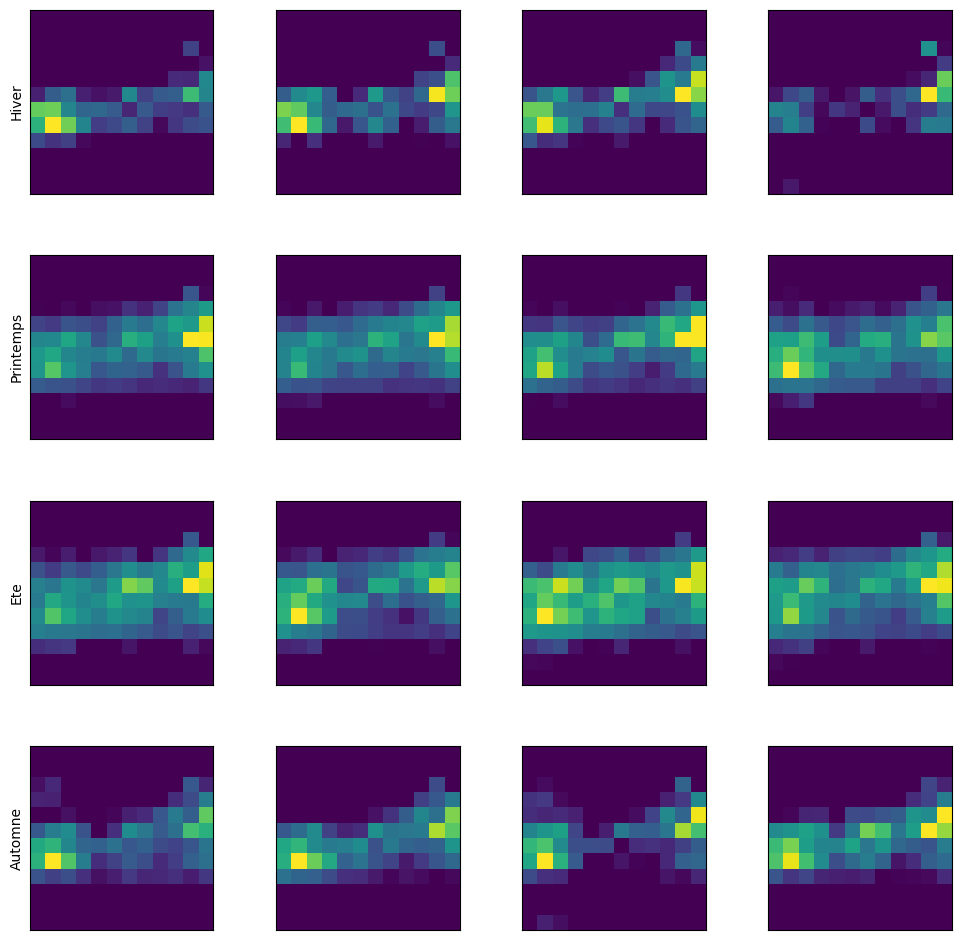

Epoch: 3 -- Generator Loss: 0.7222836017608643, Discriminator Loss: 1.3784023523330688

Took 43.556533336639404 seconds. 




100%|██████████| 1096/1096 [00:43<00:00, 25.25it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


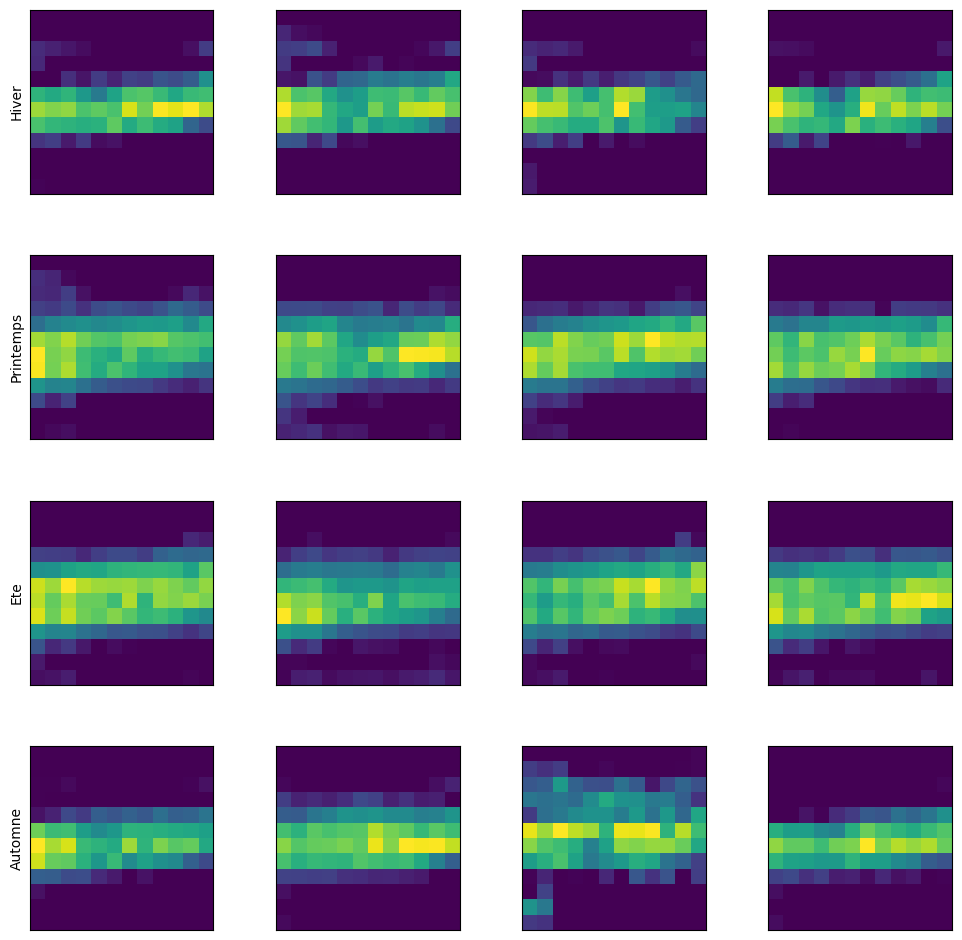

Epoch: 4 -- Generator Loss: 0.8080434799194336, Discriminator Loss: 1.3257931470870972

Took 44.17378830909729 seconds. 




100%|██████████| 1096/1096 [00:43<00:00, 25.18it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


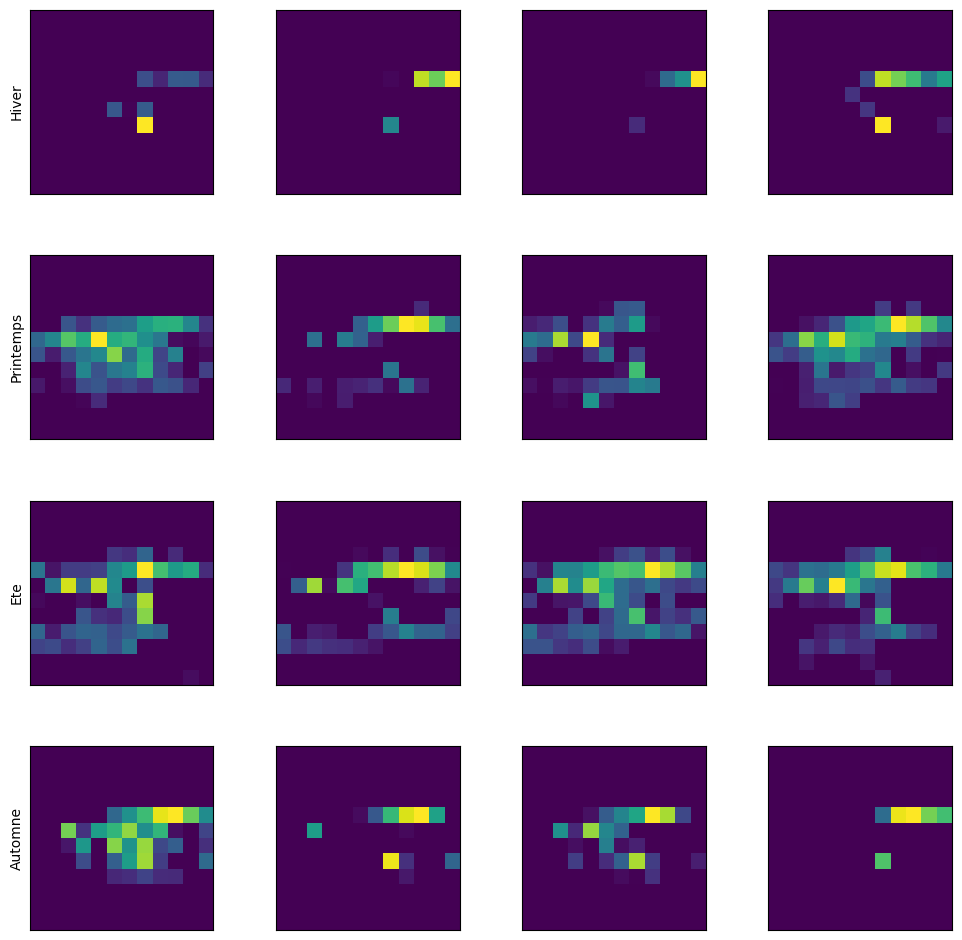

Epoch: 5 -- Generator Loss: 0.9135211706161499, Discriminator Loss: 1.2503302097320557

Took 44.33512568473816 seconds. 




100%|██████████| 1096/1096 [00:43<00:00, 25.17it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


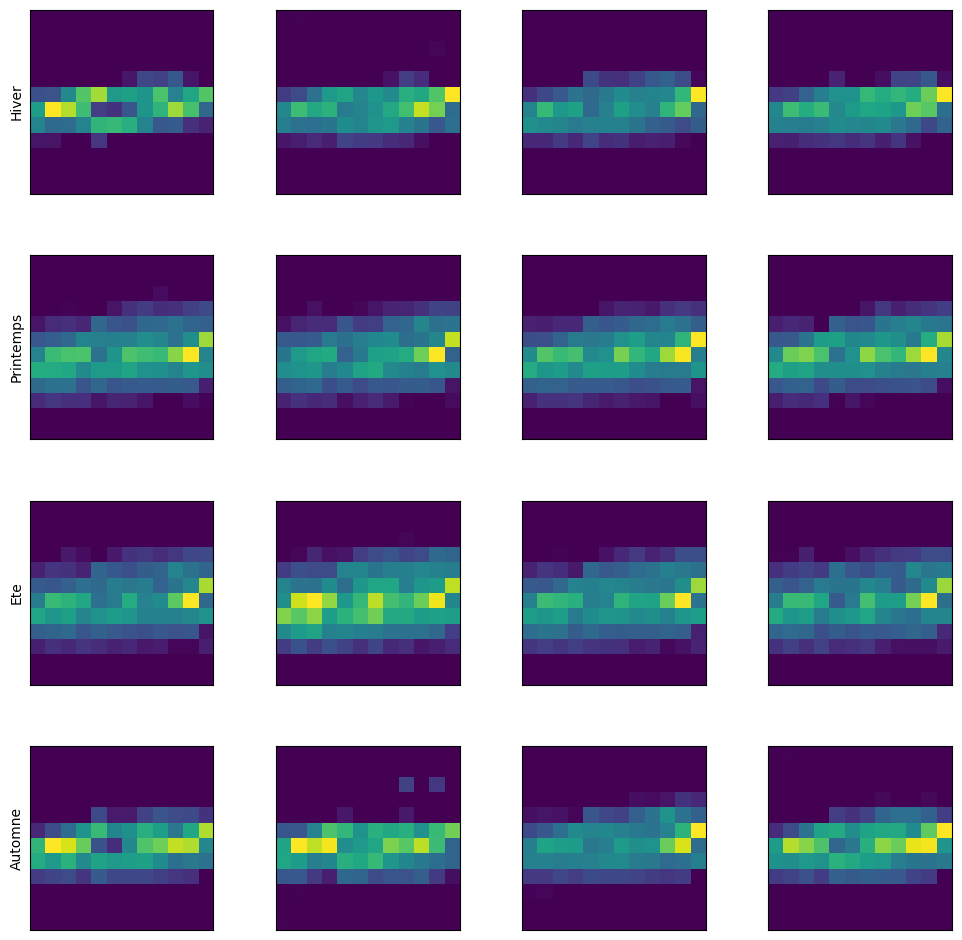

Epoch: 6 -- Generator Loss: 0.9730645418167114, Discriminator Loss: 1.1928631067276

Took 44.58207368850708 seconds. 




100%|██████████| 1096/1096 [00:42<00:00, 25.49it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


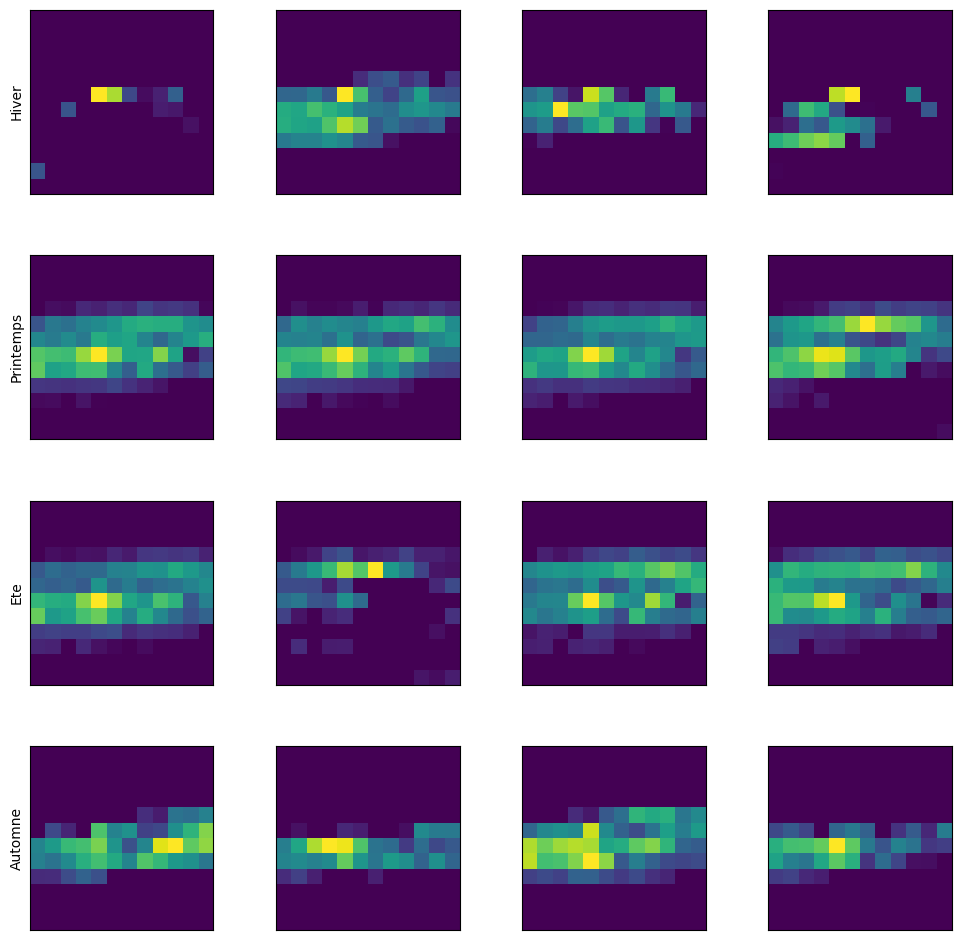

Epoch: 7 -- Generator Loss: 1.0872339010238647, Discriminator Loss: 1.1385242938995361

Took 43.828317403793335 seconds. 




100%|██████████| 1096/1096 [00:42<00:00, 25.77it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


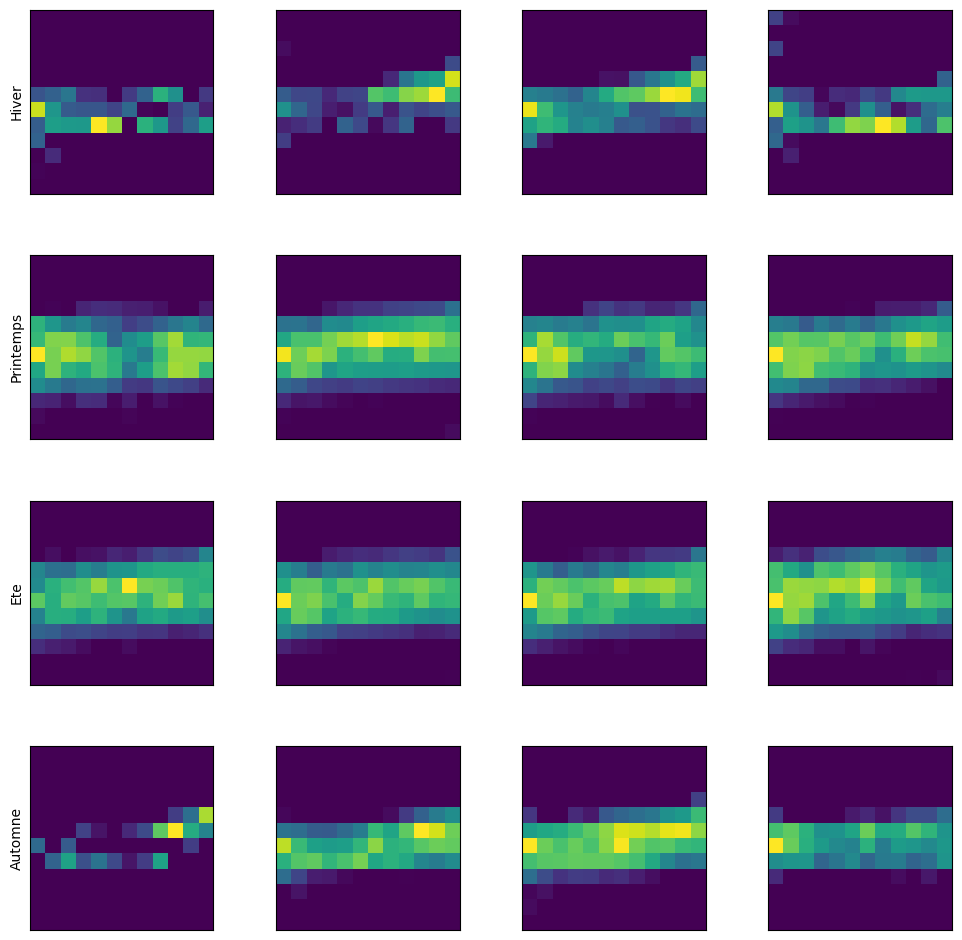

Epoch: 8 -- Generator Loss: 1.1725698709487915, Discriminator Loss: 1.093398094177246

Took 43.33426833152771 seconds. 




100%|██████████| 1096/1096 [00:42<00:00, 25.56it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


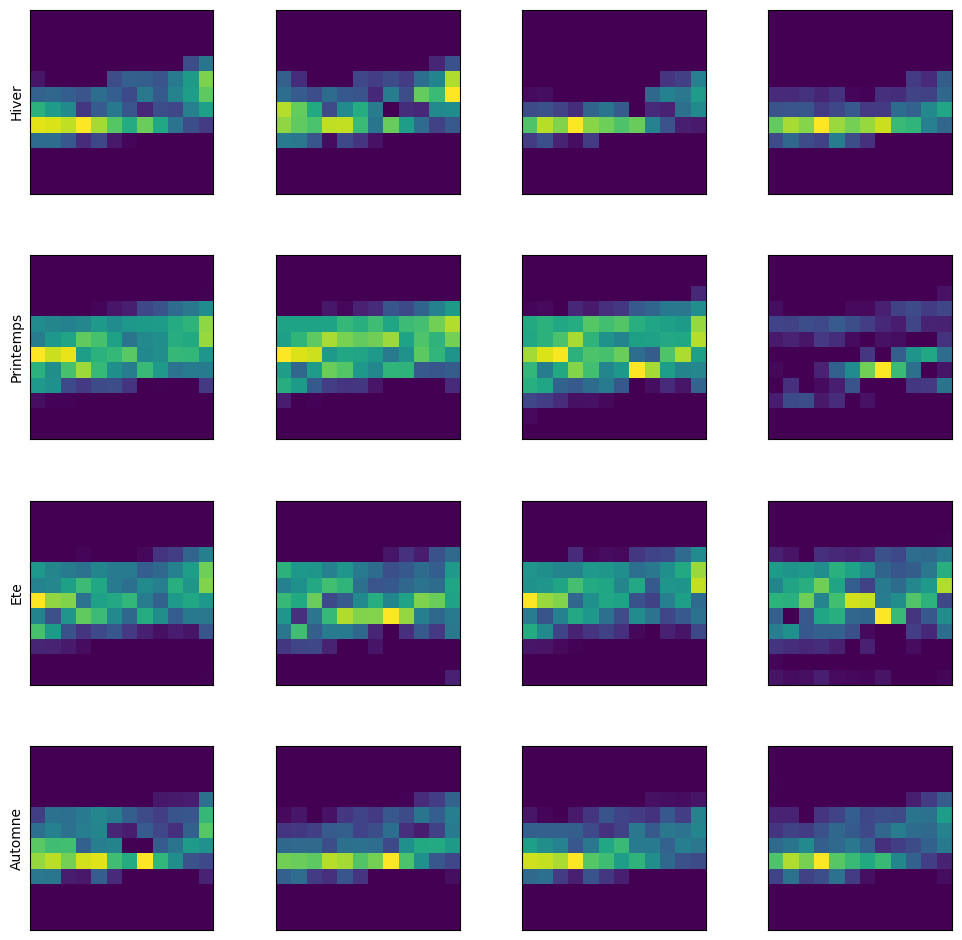

Epoch: 9 -- Generator Loss: 1.11292564868927, Discriminator Loss: 1.1217048168182373

Took 43.81139850616455 seconds. 




100%|██████████| 1096/1096 [00:43<00:00, 25.29it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


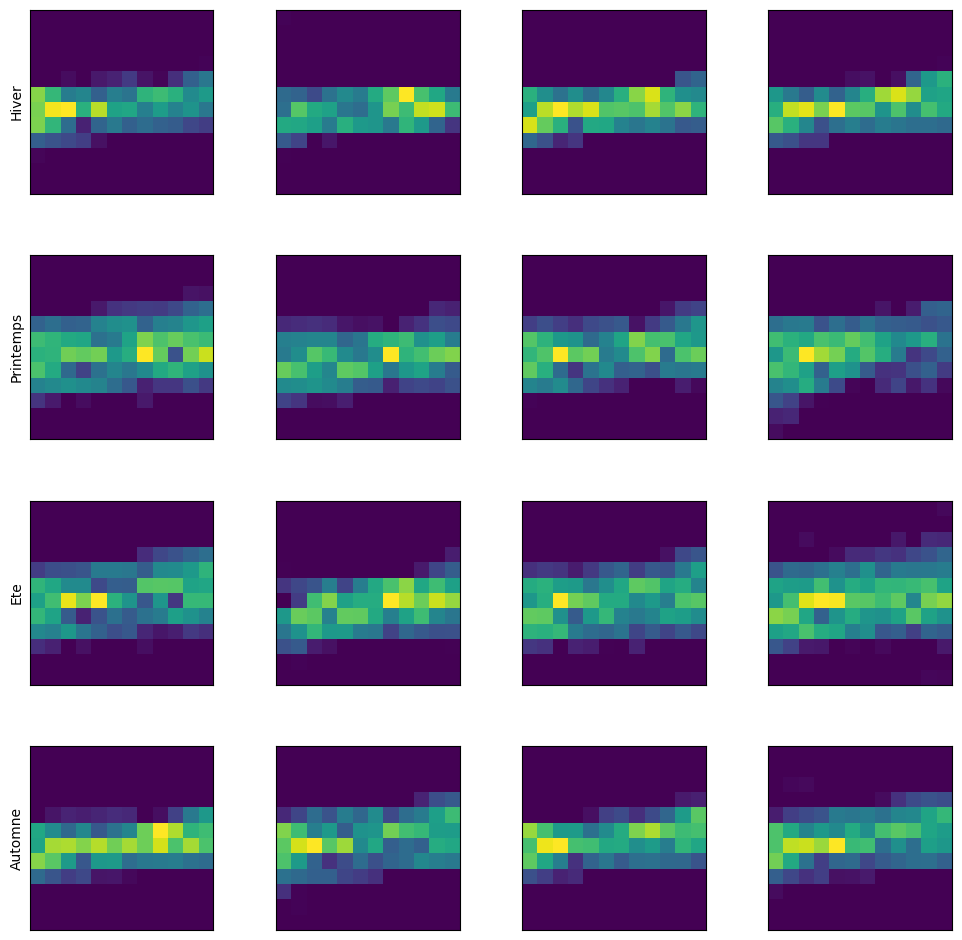

Epoch: 10 -- Generator Loss: 1.152024269104004, Discriminator Loss: 1.0883909463882446

Took 44.44541311264038 seconds. 




100%|██████████| 1096/1096 [00:41<00:00, 26.70it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


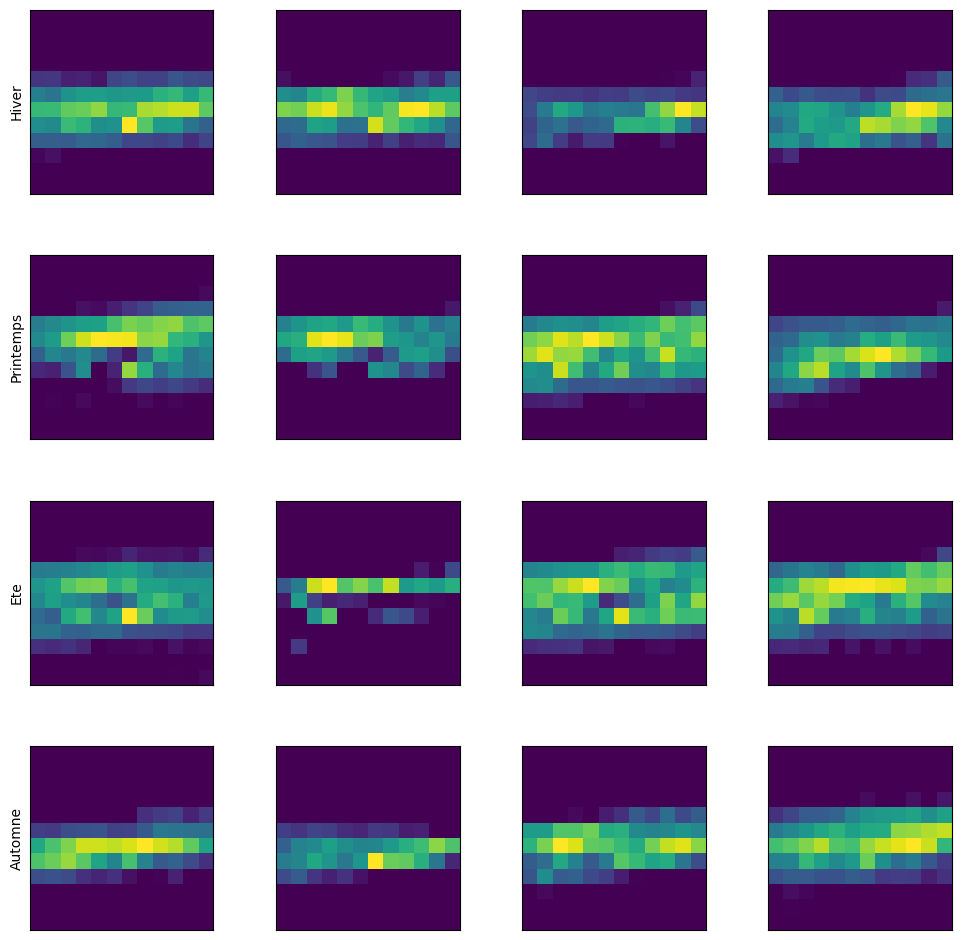

Epoch: 11 -- Generator Loss: 1.1396170854568481, Discriminator Loss: 1.1205204725265503

Took 41.8559467792511 seconds. 




100%|██████████| 1096/1096 [00:40<00:00, 26.77it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


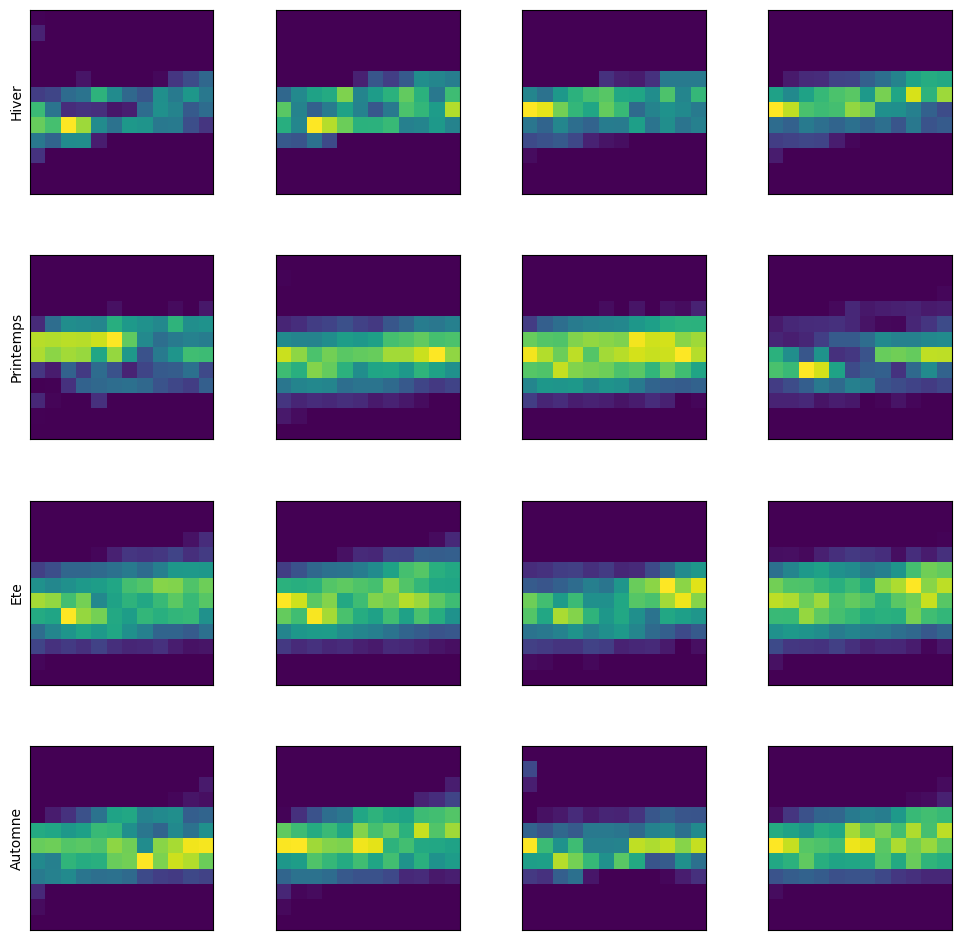

Epoch: 12 -- Generator Loss: 1.0896732807159424, Discriminator Loss: 1.1444153785705566

Took 41.68488812446594 seconds. 




100%|██████████| 1096/1096 [00:40<00:00, 26.81it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


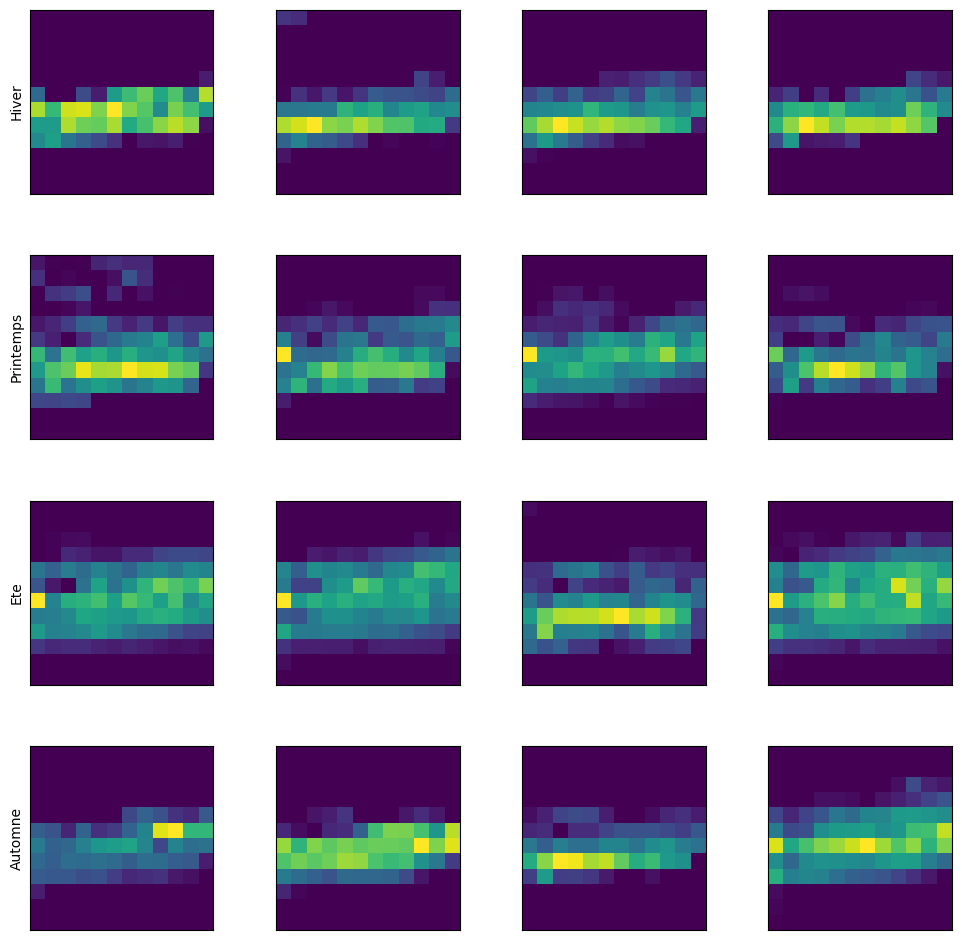

Epoch: 13 -- Generator Loss: 1.0364136695861816, Discriminator Loss: 1.1642365455627441

Took 41.71235179901123 seconds. 




100%|██████████| 1096/1096 [00:40<00:00, 26.95it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


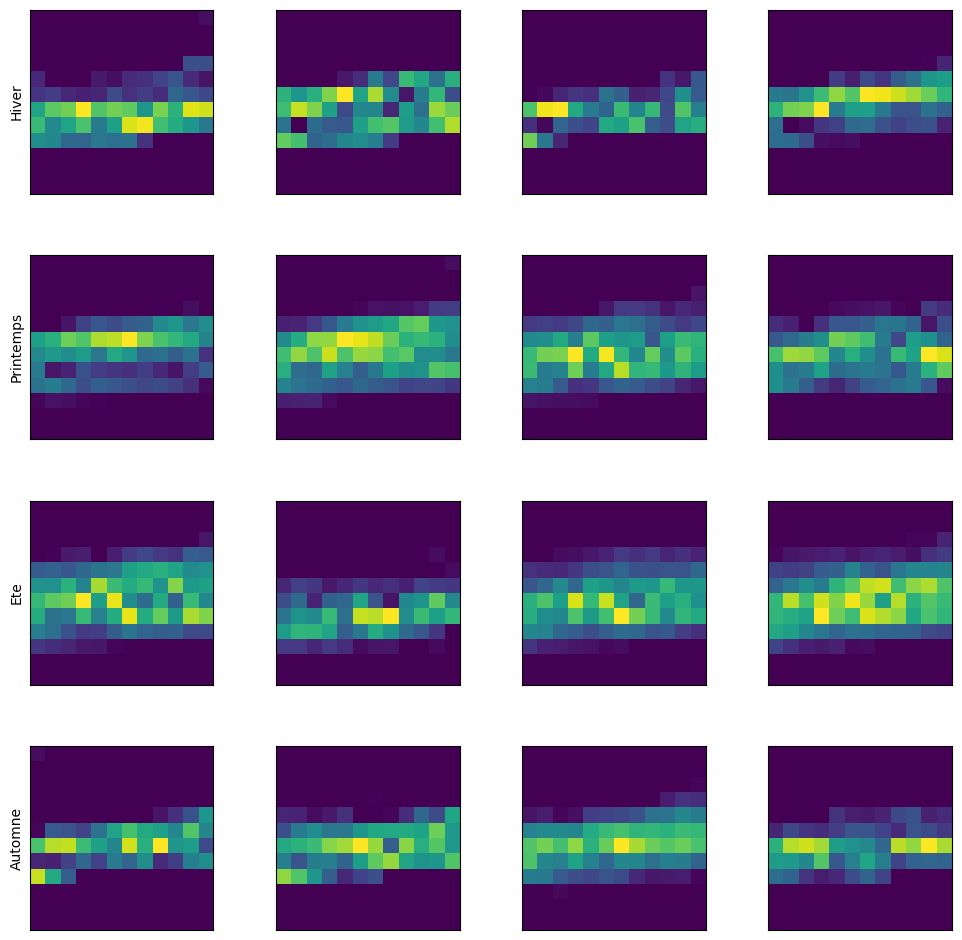

Epoch: 14 -- Generator Loss: 1.0934768915176392, Discriminator Loss: 1.115151286125183

Took 41.797221660614014 seconds. 




100%|██████████| 1096/1096 [00:40<00:00, 26.77it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


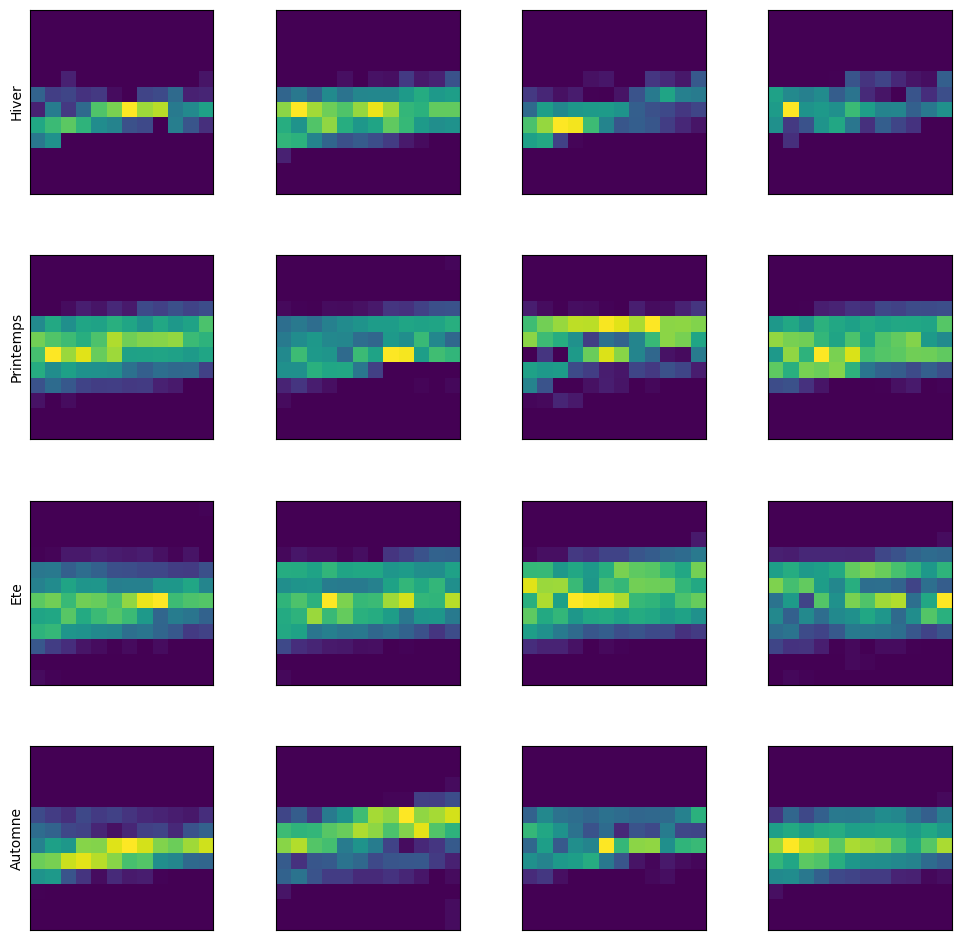

Epoch: 15 -- Generator Loss: 1.0392589569091797, Discriminator Loss: 1.1638808250427246

Took 41.712459087371826 seconds. 




100%|██████████| 1096/1096 [00:40<00:00, 26.77it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


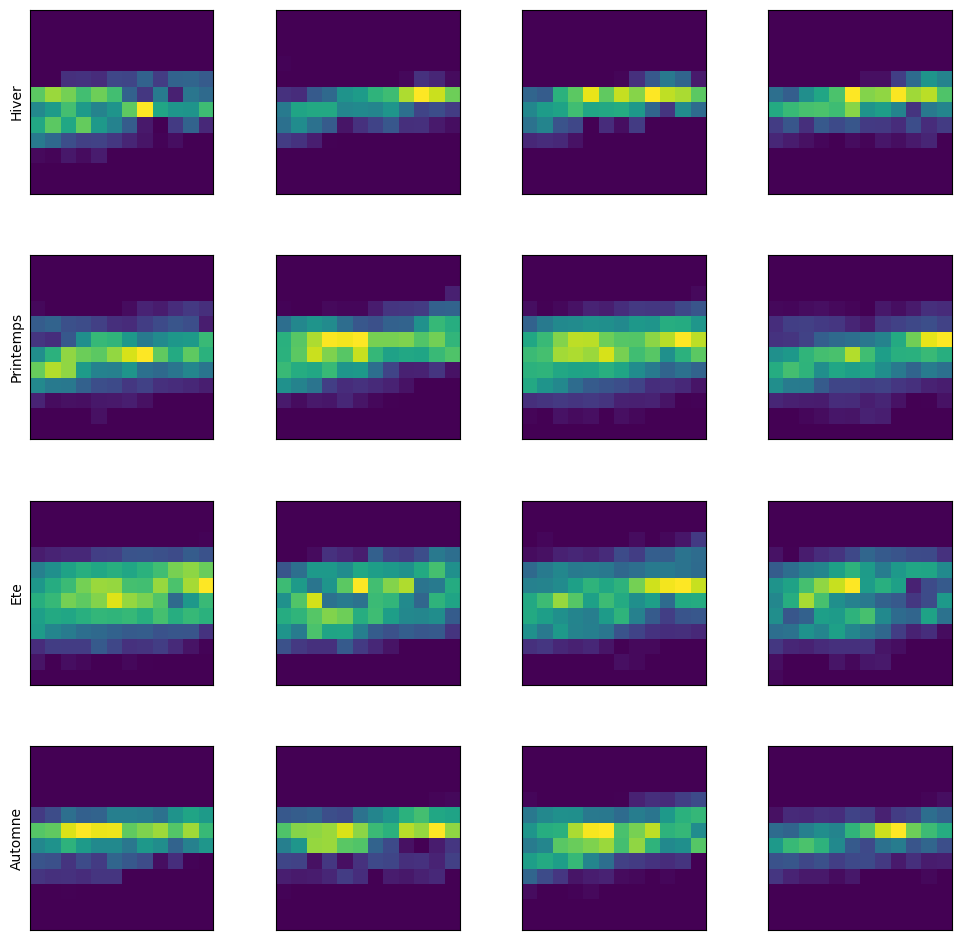

Epoch: 16 -- Generator Loss: 1.0714393854141235, Discriminator Loss: 1.1252083778381348

Took 41.83057165145874 seconds. 




100%|██████████| 1096/1096 [13:38:22<00:00, 44.80s/it]     


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


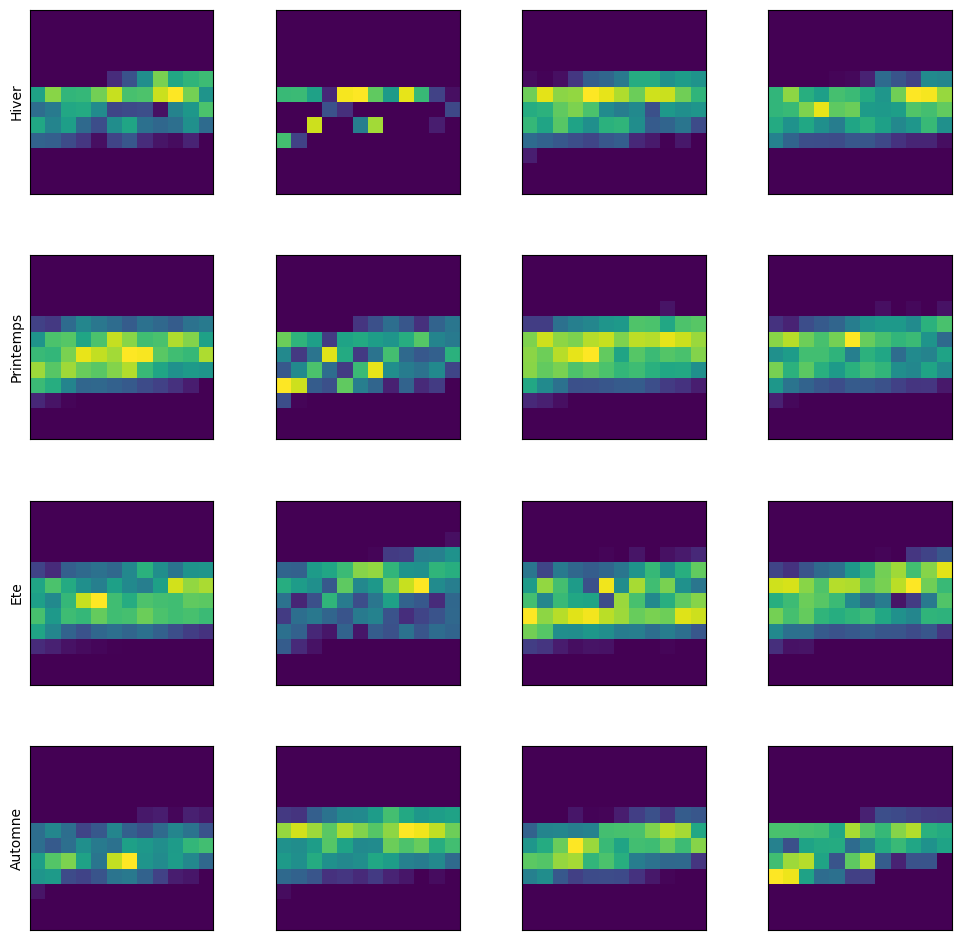

Epoch: 17 -- Generator Loss: 1.0246555805206299, Discriminator Loss: 1.1634851694107056

Took 49103.069997787476 seconds. 




100%|██████████| 1096/1096 [00:41<00:00, 26.58it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


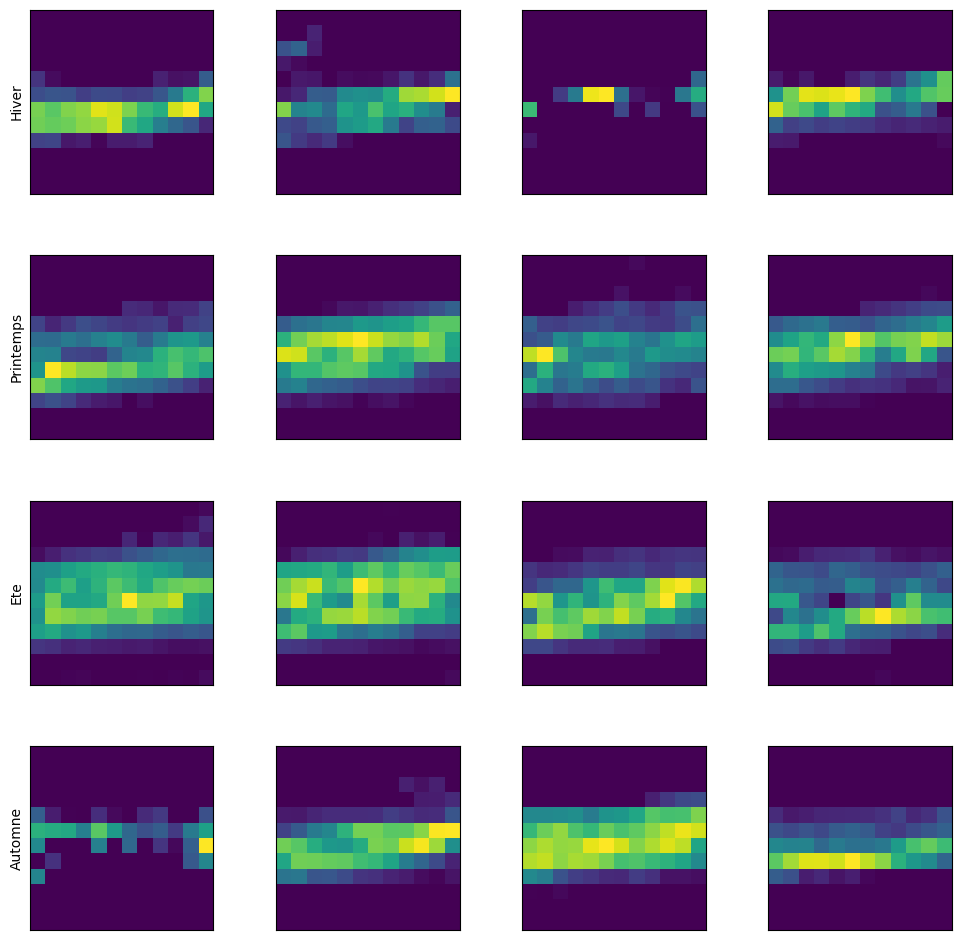

Epoch: 18 -- Generator Loss: 1.027167558670044, Discriminator Loss: 1.140918254852295

Took 42.26885414123535 seconds. 




100%|██████████| 1096/1096 [00:40<00:00, 27.32it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


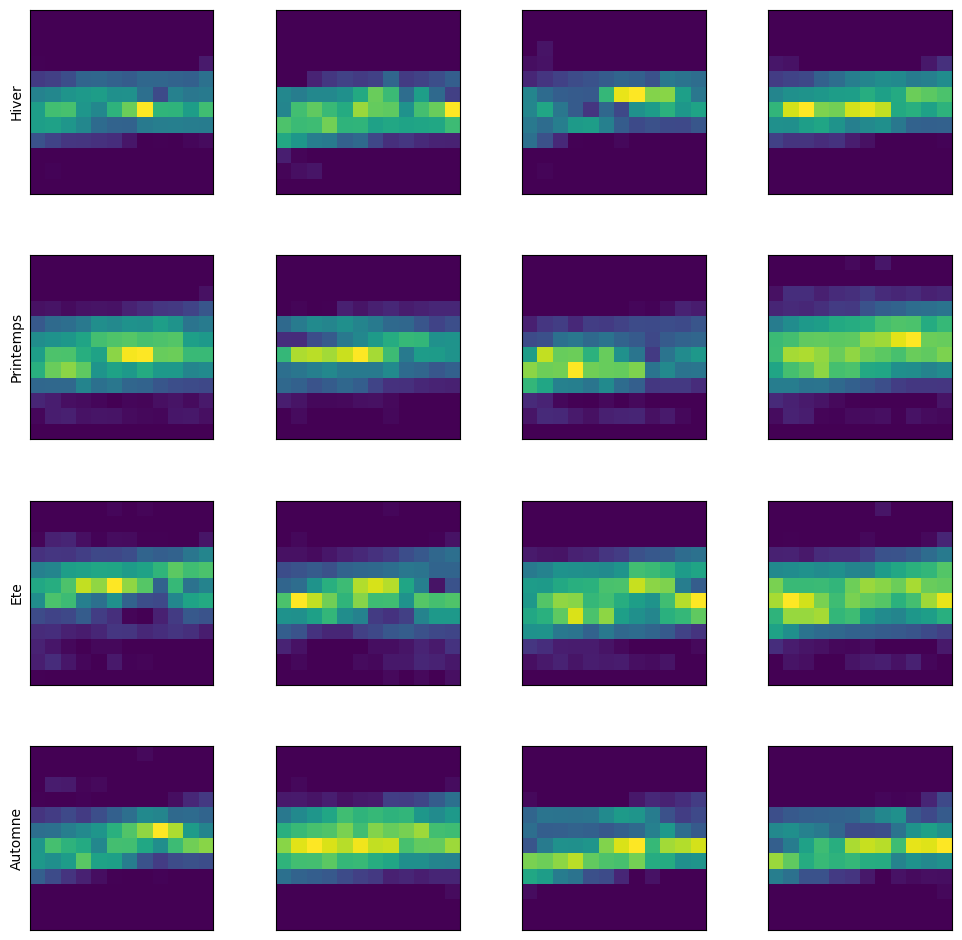

Epoch: 19 -- Generator Loss: 1.115713357925415, Discriminator Loss: 1.0966817140579224

Took 40.99450469017029 seconds. 




100%|██████████| 1096/1096 [00:43<00:00, 24.99it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


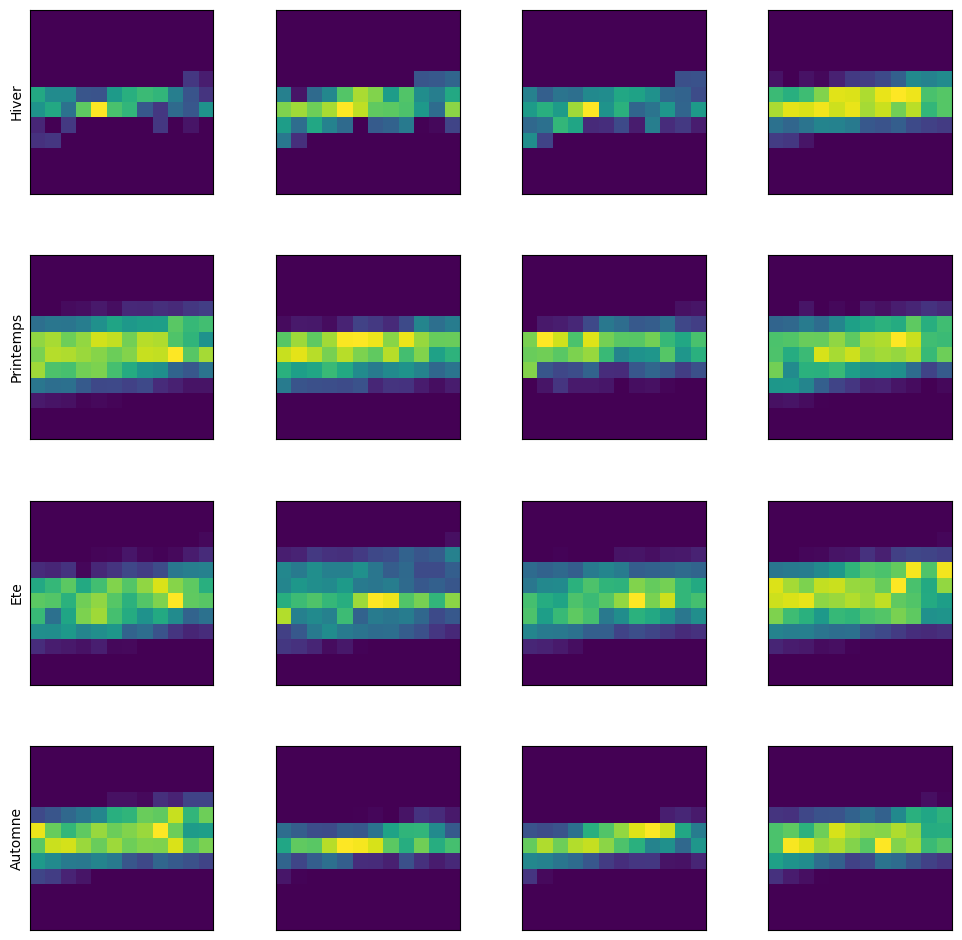

Epoch: 20 -- Generator Loss: 1.061661958694458, Discriminator Loss: 1.142106294631958

Took 44.701016902923584 seconds. 




100%|██████████| 1096/1096 [00:44<00:00, 24.40it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


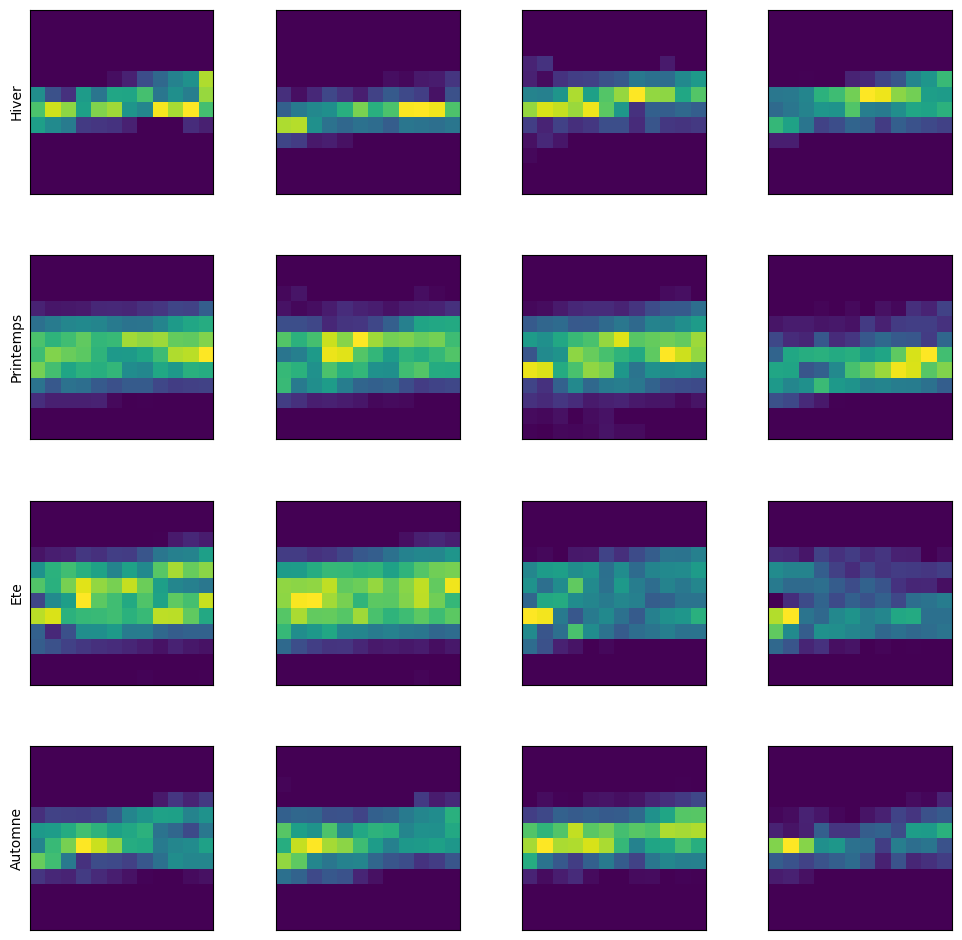

Epoch: 21 -- Generator Loss: 1.15314519405365, Discriminator Loss: 1.060755968093872

Took 45.754051208496094 seconds. 




100%|██████████| 1096/1096 [00:45<00:00, 24.01it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


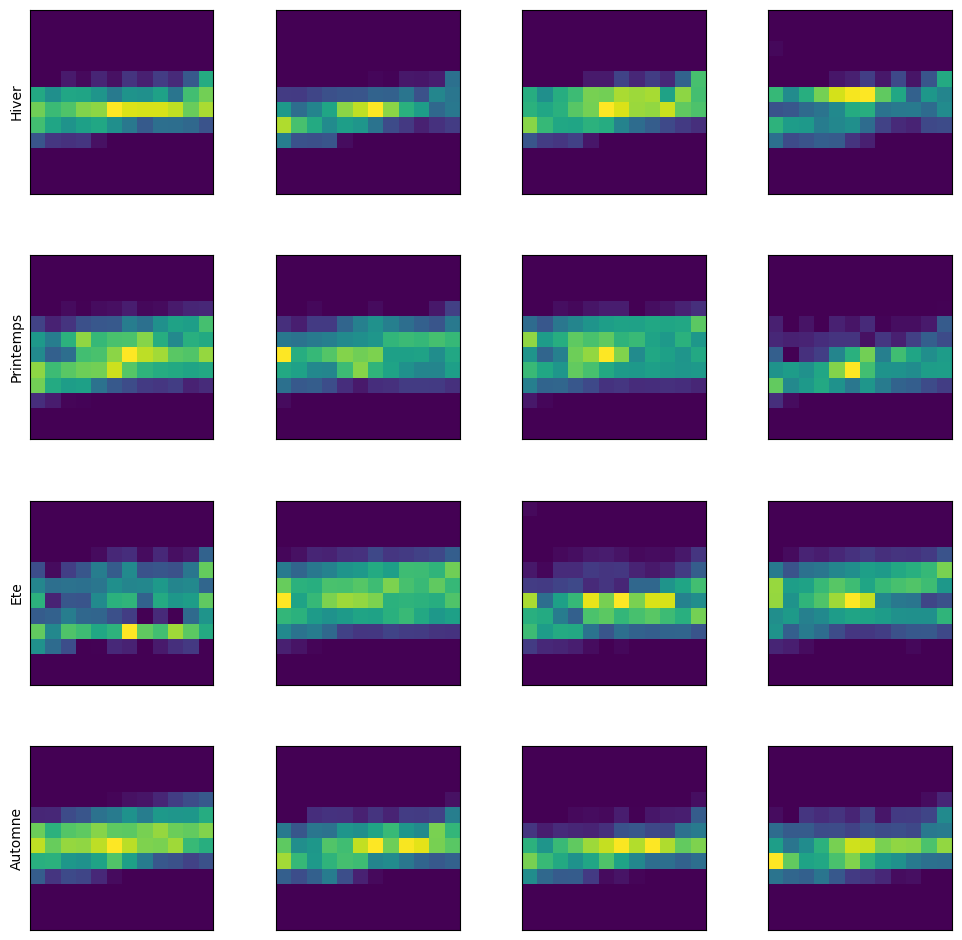

Epoch: 22 -- Generator Loss: 1.1760398149490356, Discriminator Loss: 1.077451467514038

Took 46.76744842529297 seconds. 




100%|██████████| 1096/1096 [00:44<00:00, 24.56it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


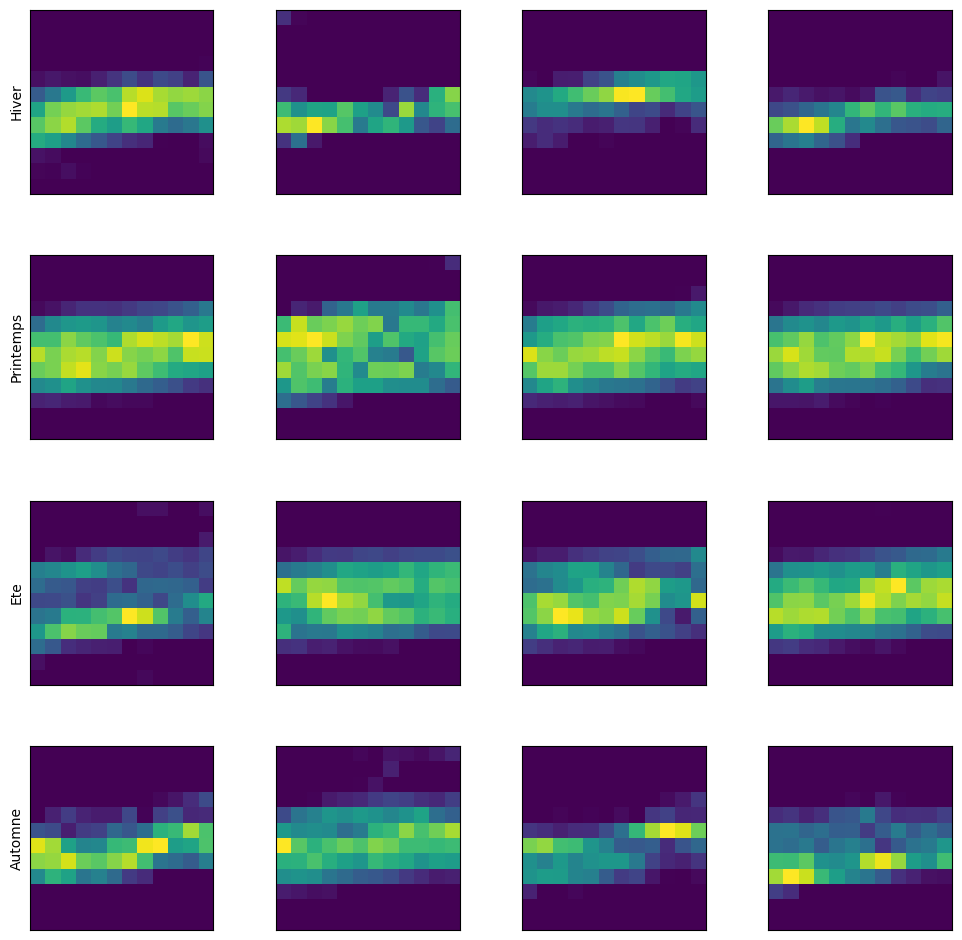

Epoch: 23 -- Generator Loss: 1.1282172203063965, Discriminator Loss: 1.0763784646987915

Took 45.534098386764526 seconds. 




100%|██████████| 1096/1096 [00:44<00:00, 24.66it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


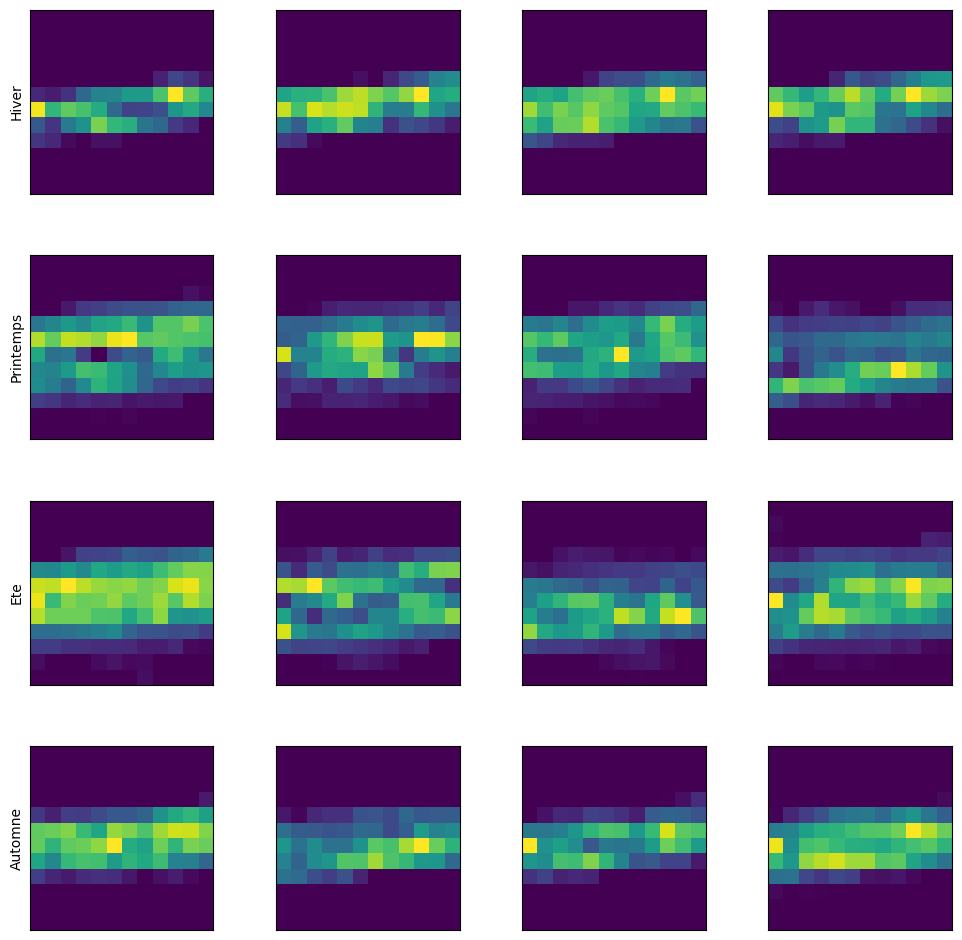

Epoch: 24 -- Generator Loss: 1.111401915550232, Discriminator Loss: 1.1155116558074951

Took 45.22460222244263 seconds. 




100%|██████████| 1096/1096 [00:45<00:00, 24.06it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


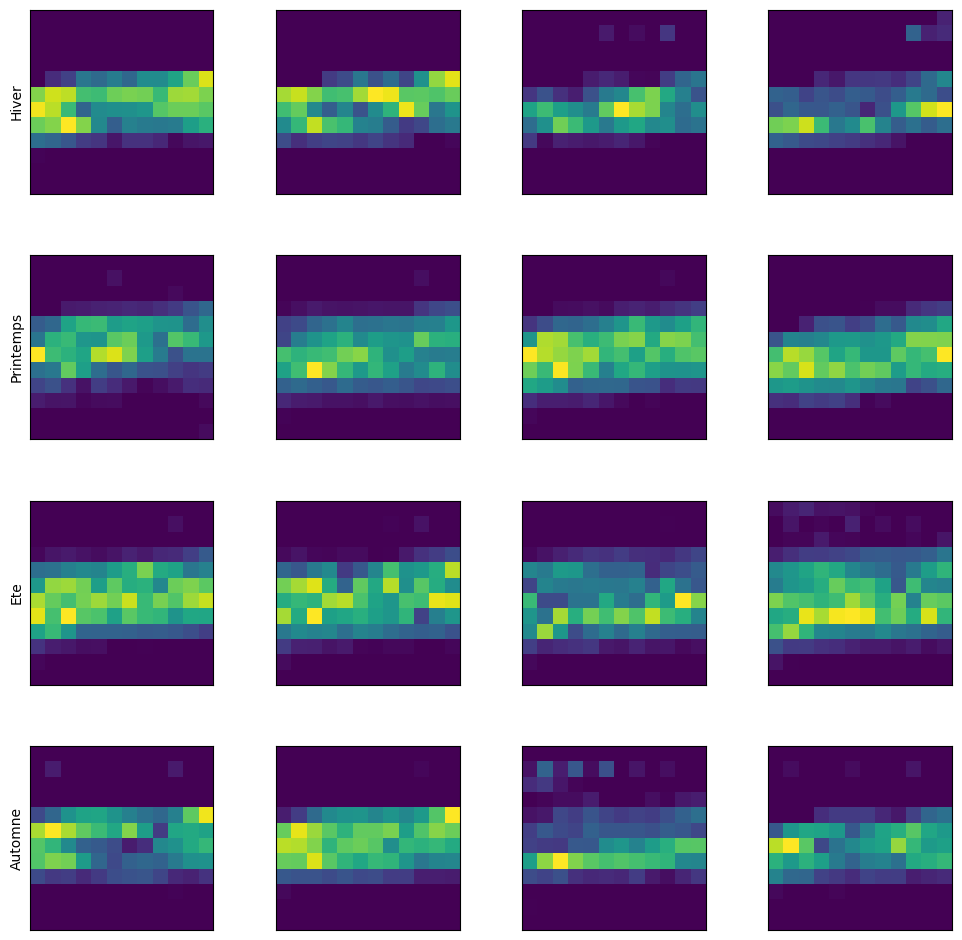

Epoch: 25 -- Generator Loss: 1.2294682264328003, Discriminator Loss: 1.050291657447815

Took 46.593937397003174 seconds. 




100%|██████████| 1096/1096 [00:45<00:00, 24.09it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


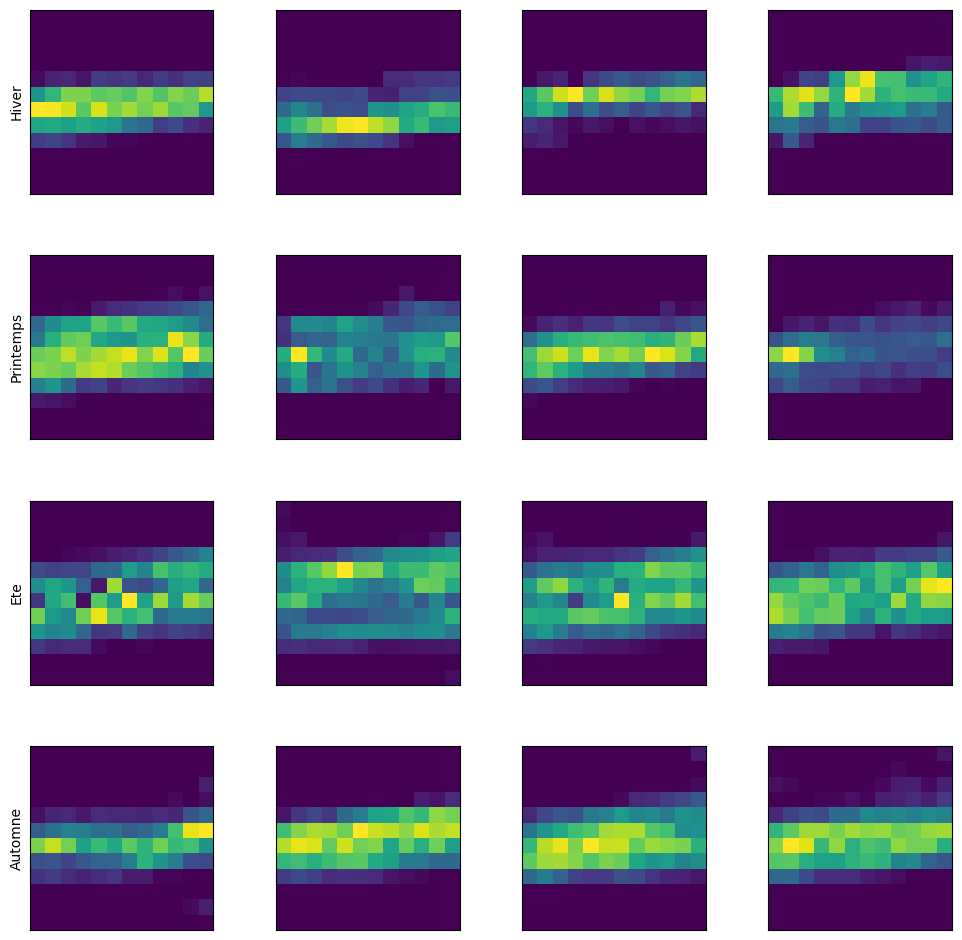

Epoch: 26 -- Generator Loss: 1.206078290939331, Discriminator Loss: 1.052591323852539

Took 47.03445529937744 seconds. 




100%|██████████| 1096/1096 [00:47<00:00, 23.24it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


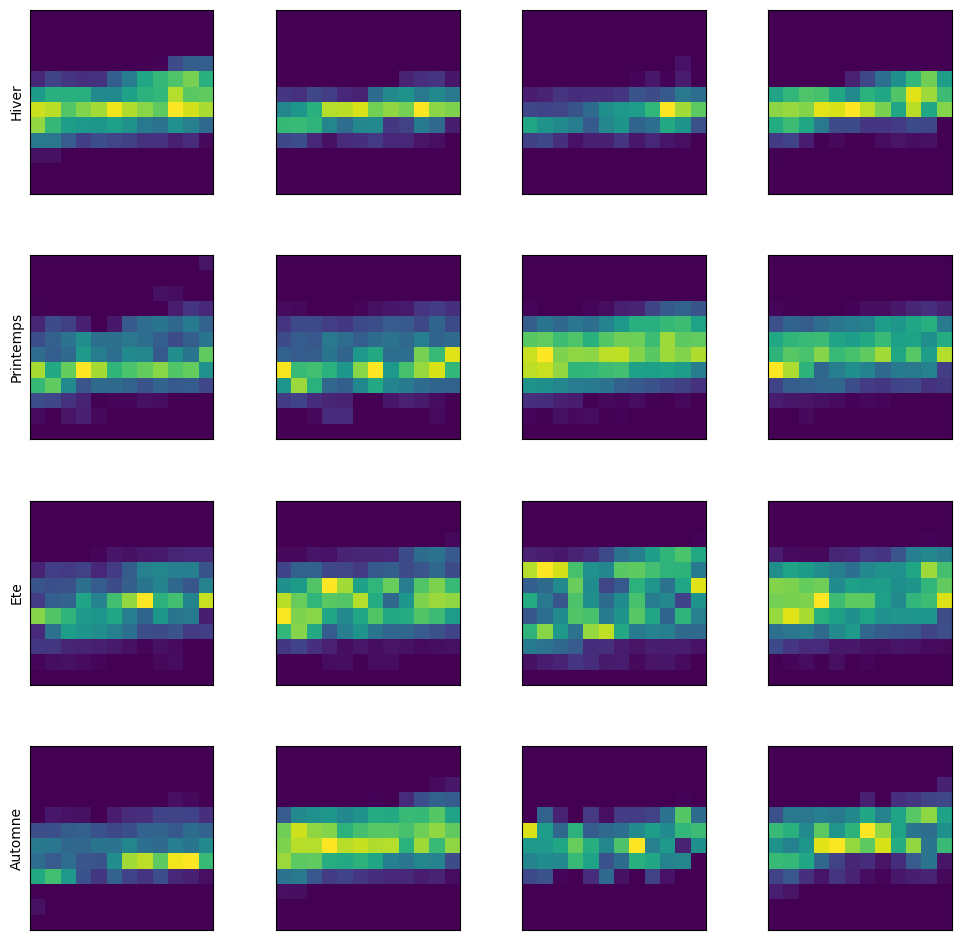

Epoch: 27 -- Generator Loss: 1.1947791576385498, Discriminator Loss: 1.0960009098052979

Took 48.19765496253967 seconds. 




100%|██████████| 1096/1096 [00:44<00:00, 24.57it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


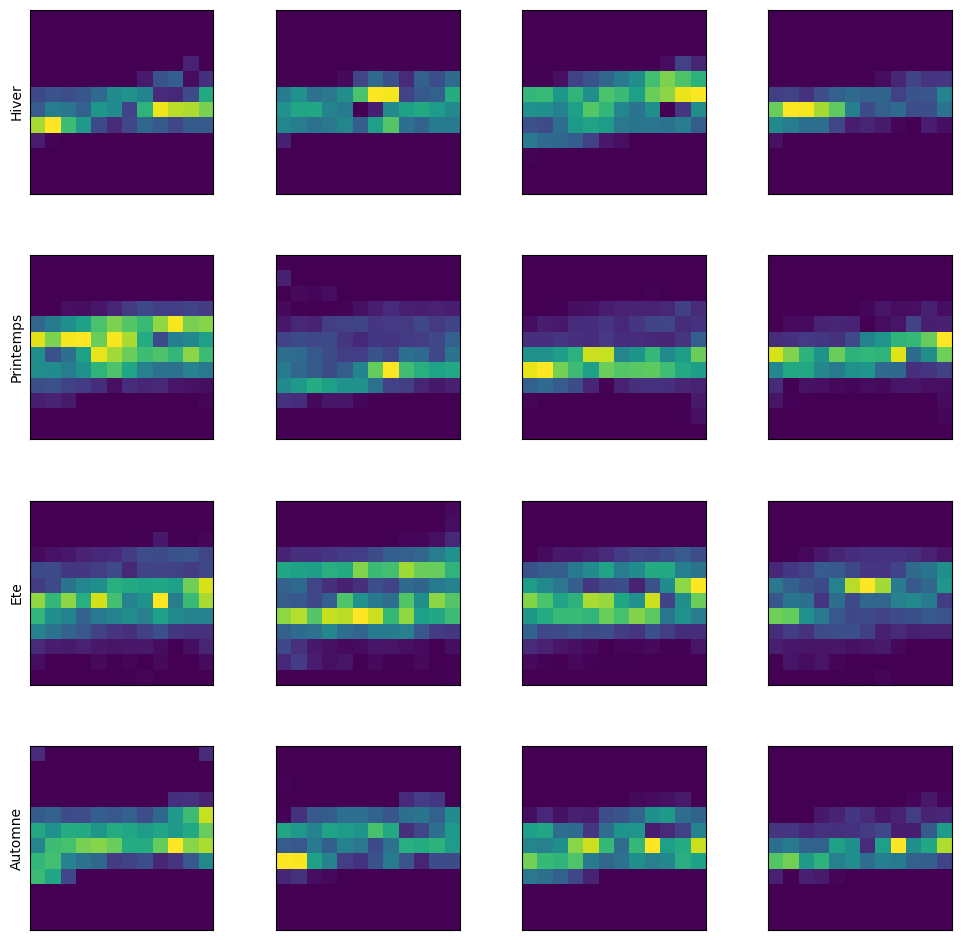

Epoch: 28 -- Generator Loss: 1.2529363632202148, Discriminator Loss: 1.0599128007888794

Took 45.61598253250122 seconds. 




100%|██████████| 1096/1096 [00:44<00:00, 24.73it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


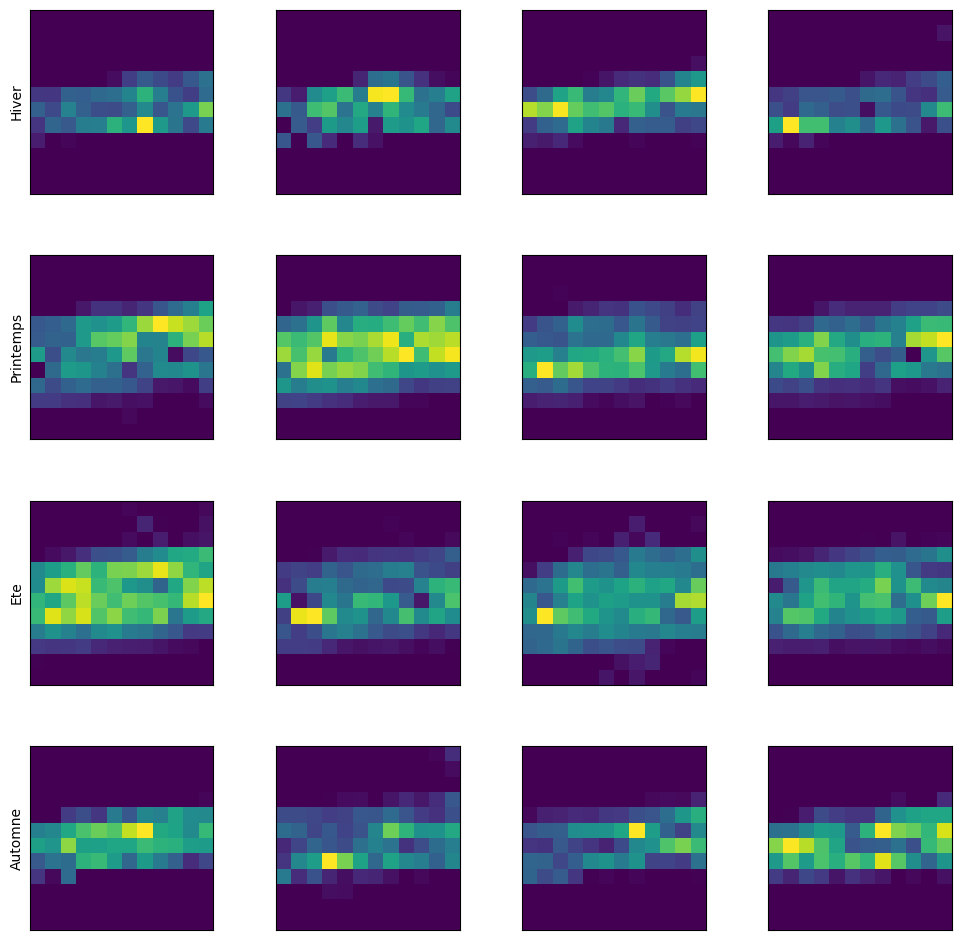

Epoch: 29 -- Generator Loss: 1.2399108409881592, Discriminator Loss: 1.026146650314331

Took 45.394031286239624 seconds. 




100%|██████████| 1096/1096 [00:44<00:00, 24.81it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


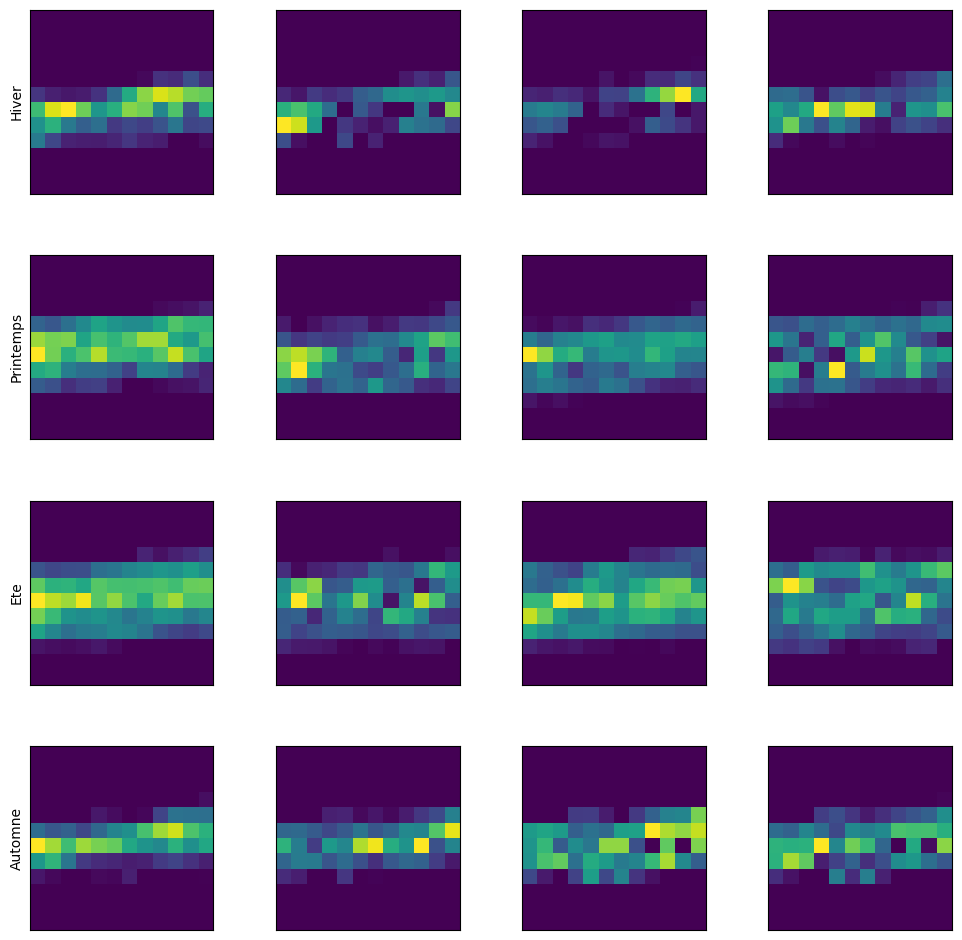

Epoch: 30 -- Generator Loss: 1.2827932834625244, Discriminator Loss: 1.042295217514038

Took 45.33592772483826 seconds. 




100%|██████████| 1096/1096 [00:45<00:00, 24.06it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


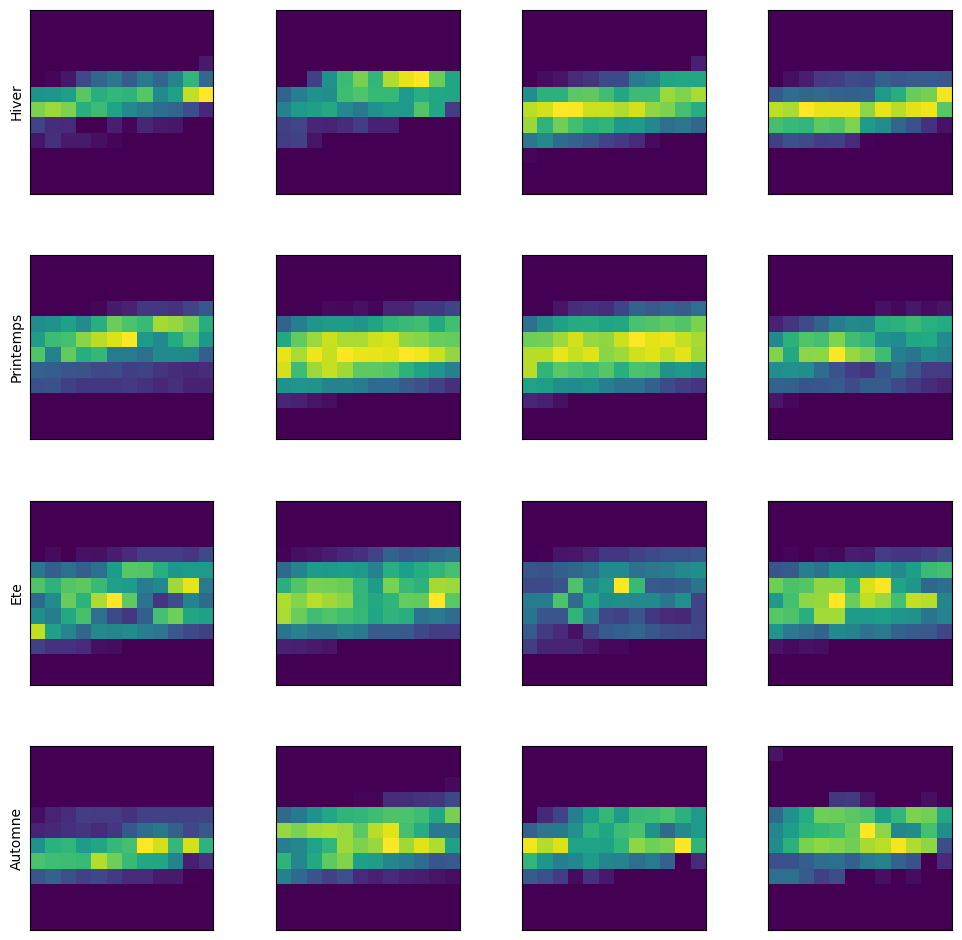

Epoch: 31 -- Generator Loss: 1.3027729988098145, Discriminator Loss: 1.0096712112426758

Took 46.57475757598877 seconds. 




100%|██████████| 1096/1096 [00:45<00:00, 24.28it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


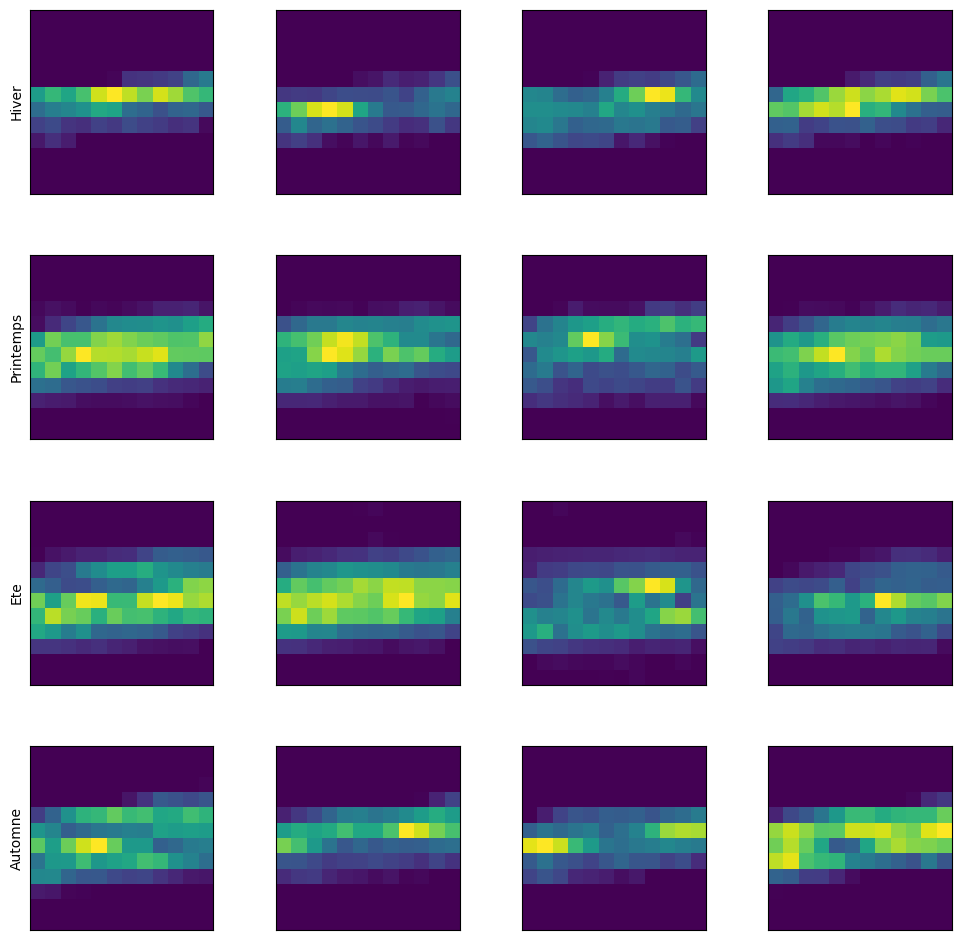

Epoch: 32 -- Generator Loss: 1.3862128257751465, Discriminator Loss: 0.9567817449569702

Took 45.977025747299194 seconds. 




100%|██████████| 1096/1096 [00:44<00:00, 24.46it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


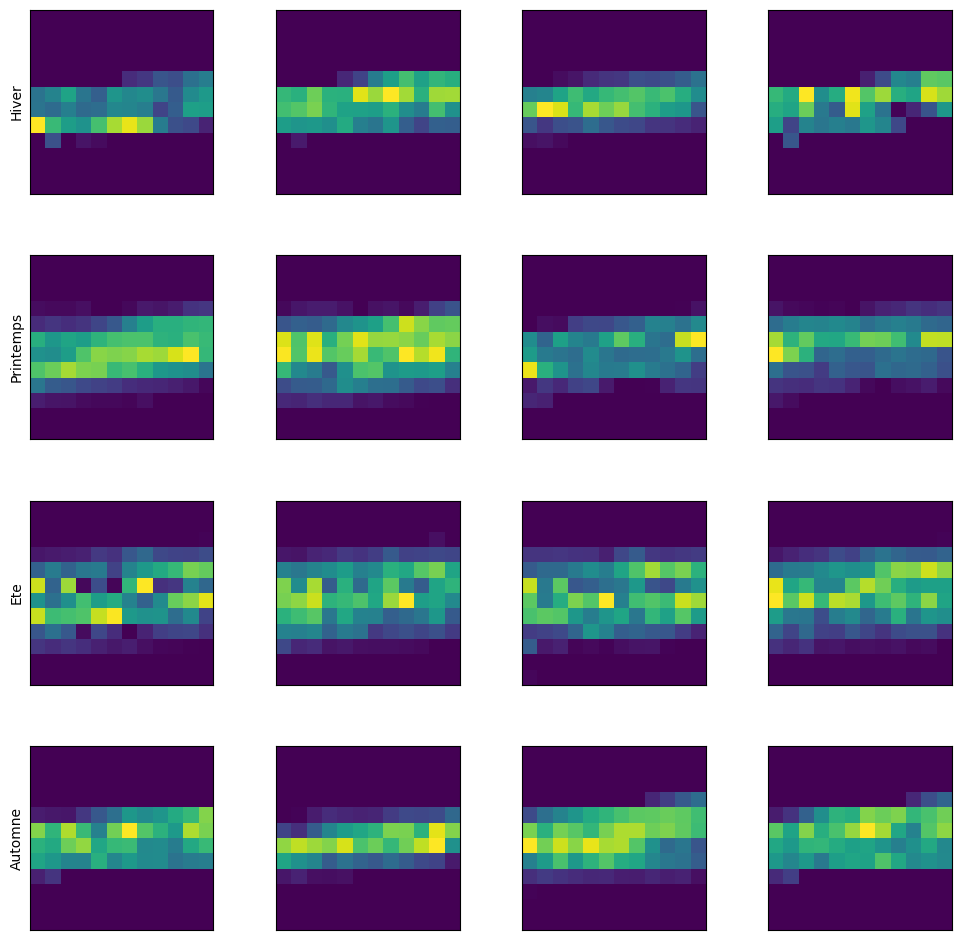

Epoch: 33 -- Generator Loss: 1.3089808225631714, Discriminator Loss: 0.9807407259941101

Took 45.56626009941101 seconds. 




100%|██████████| 1096/1096 [00:42<00:00, 25.76it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


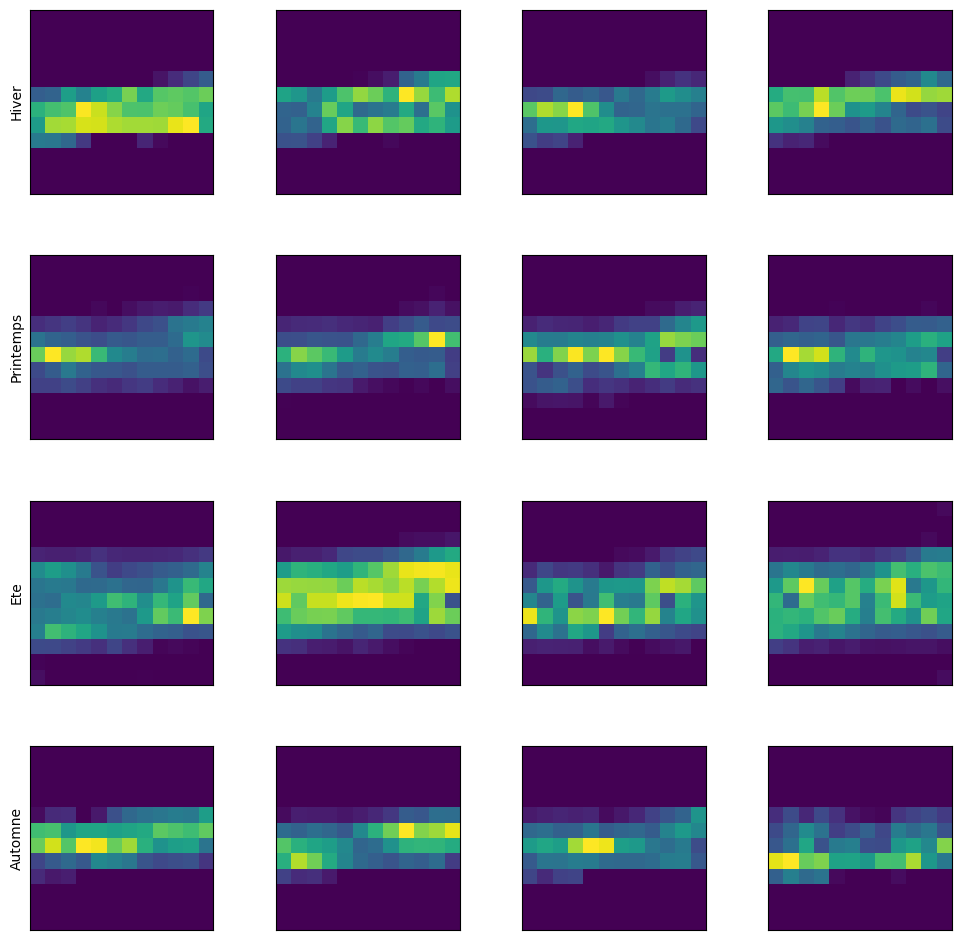

Epoch: 34 -- Generator Loss: 1.3054068088531494, Discriminator Loss: 1.0075350999832153

Took 43.630587339401245 seconds. 




100%|██████████| 1096/1096 [00:42<00:00, 25.69it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


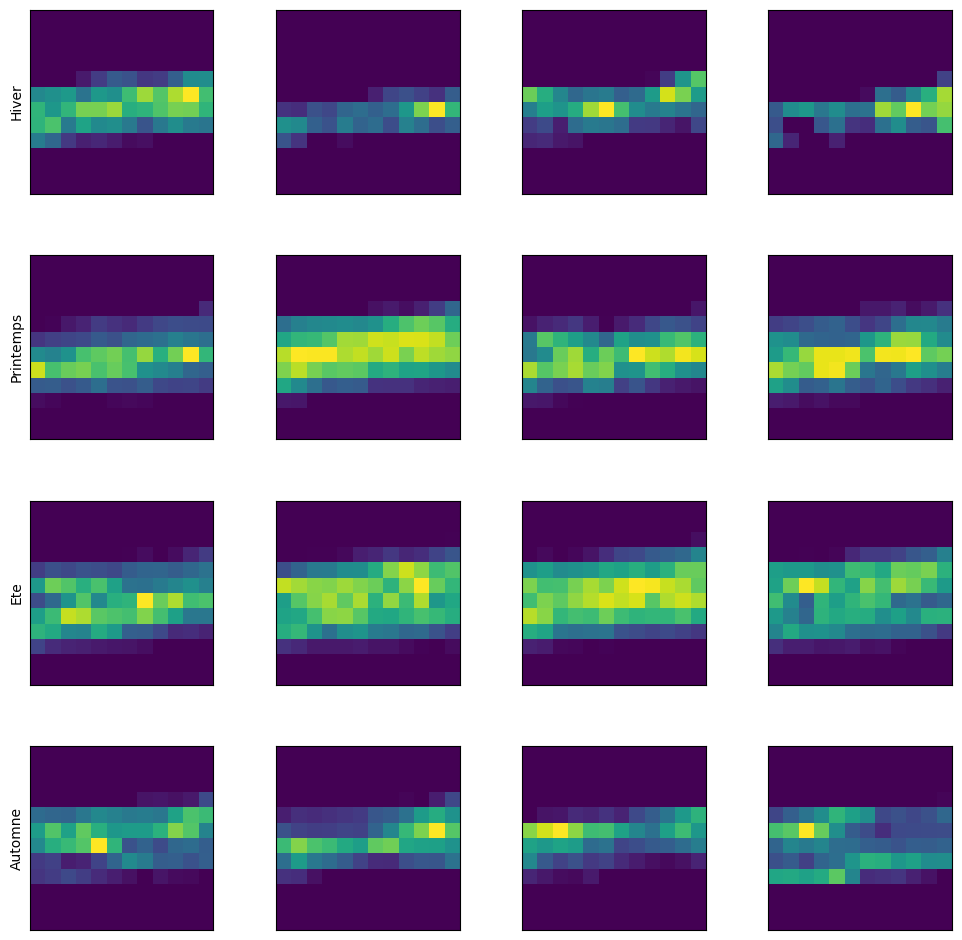

Epoch: 35 -- Generator Loss: 1.412552833557129, Discriminator Loss: 0.9459738731384277

Took 43.479244232177734 seconds. 




100%|██████████| 1096/1096 [00:42<00:00, 25.92it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


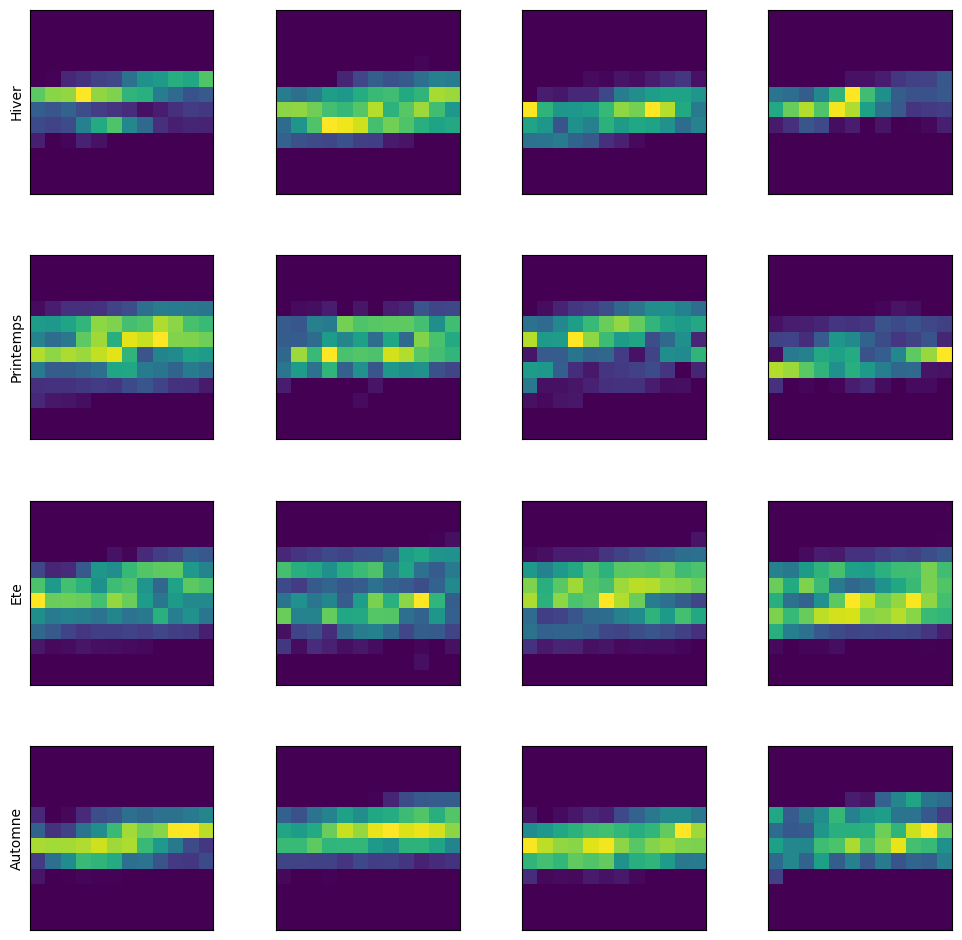

Epoch: 36 -- Generator Loss: 1.4815996885299683, Discriminator Loss: 0.8957276940345764

Took 43.054744482040405 seconds. 




100%|██████████| 1096/1096 [00:43<00:00, 25.08it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


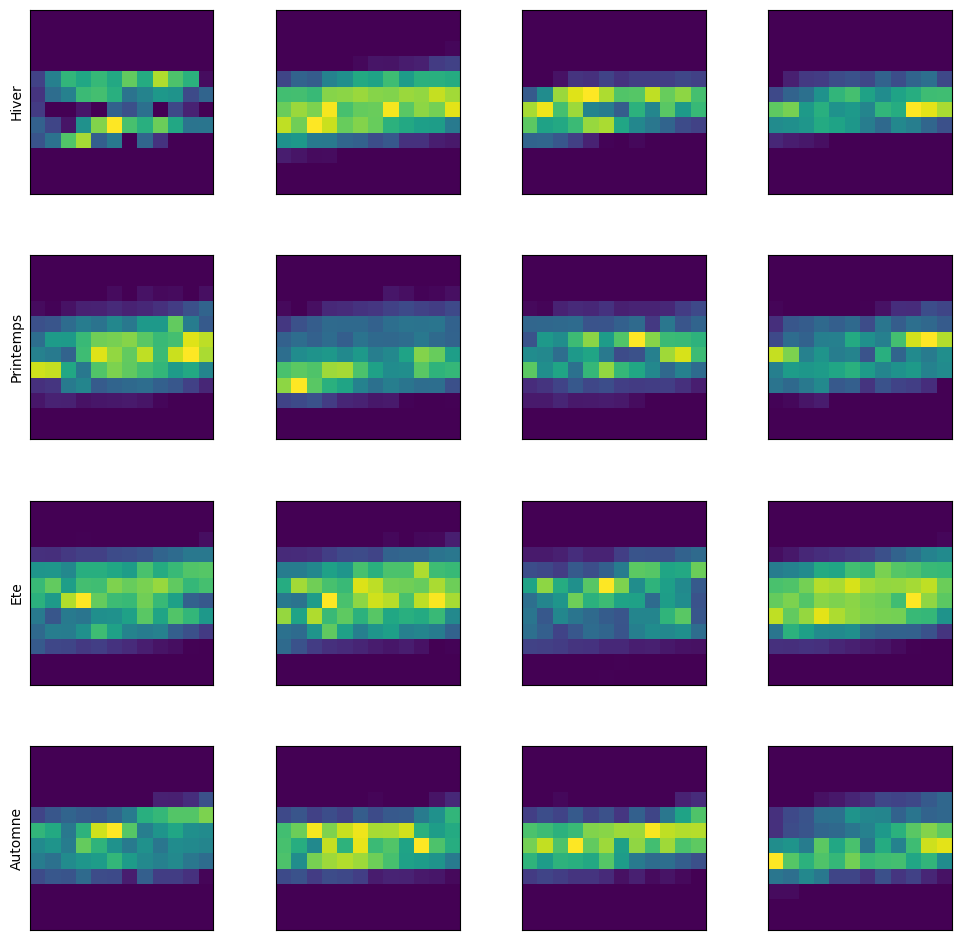

Epoch: 37 -- Generator Loss: 1.419119954109192, Discriminator Loss: 0.9691436290740967

Took 44.485936641693115 seconds. 




100%|██████████| 1096/1096 [00:43<00:00, 25.21it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


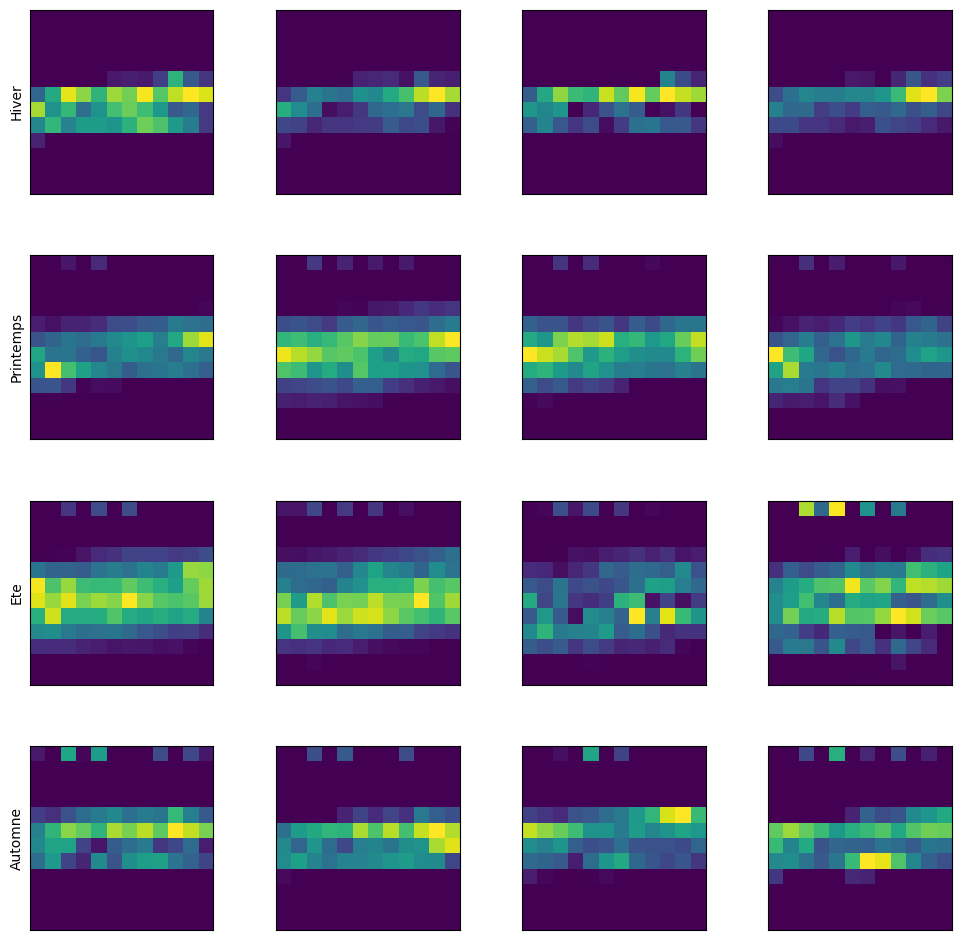

Epoch: 38 -- Generator Loss: 1.409597635269165, Discriminator Loss: 0.9632783532142639

Took 44.82646298408508 seconds. 




100%|██████████| 1096/1096 [00:42<00:00, 25.98it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


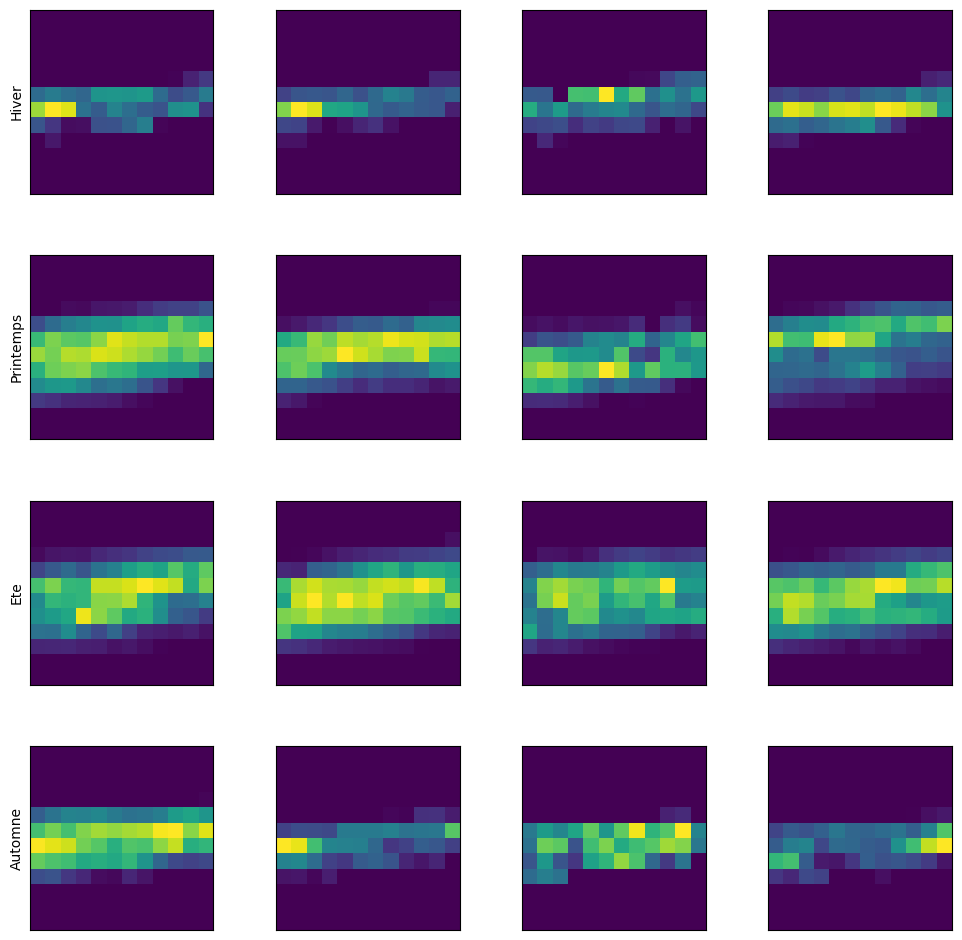

Epoch: 39 -- Generator Loss: 1.5217665433883667, Discriminator Loss: 0.900390088558197

Took 42.95059609413147 seconds. 




100%|██████████| 1096/1096 [00:42<00:00, 25.93it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


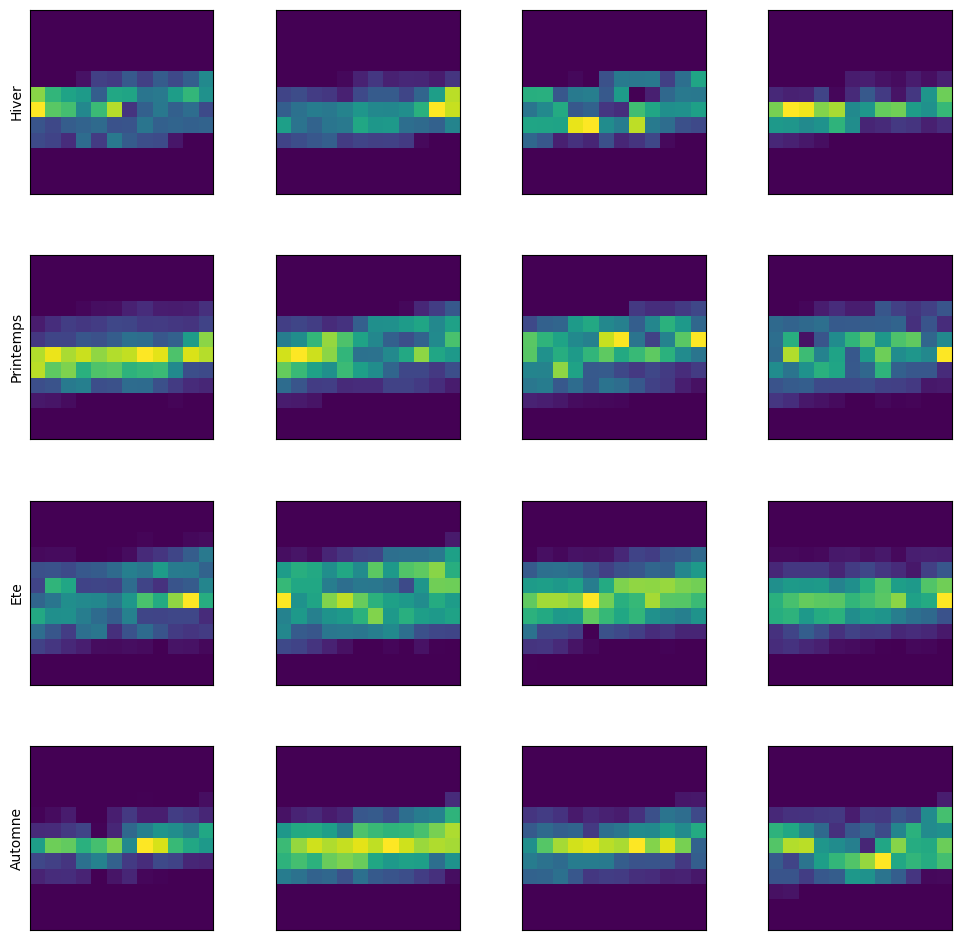

Epoch: 40 -- Generator Loss: 1.4759124517440796, Discriminator Loss: 0.9005948901176453

Took 43.089223861694336 seconds. 




100%|██████████| 1096/1096 [00:42<00:00, 25.76it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


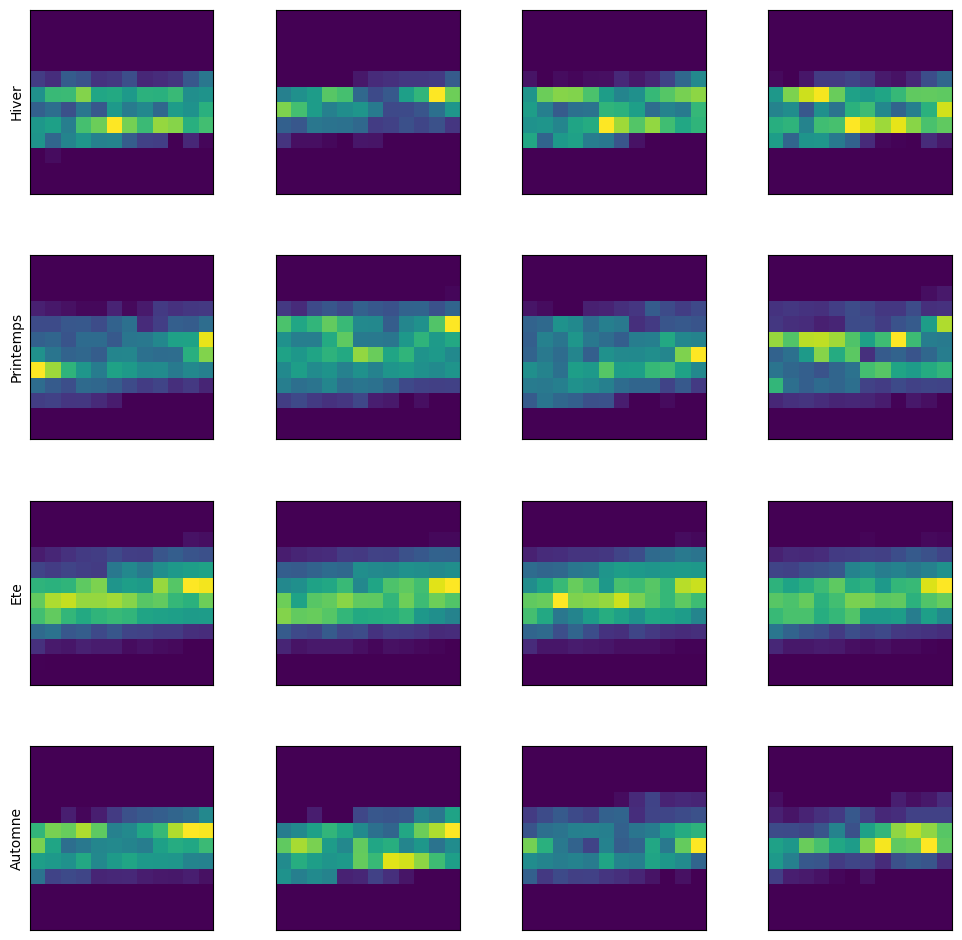

Epoch: 41 -- Generator Loss: 1.5765912532806396, Discriminator Loss: 0.8960318565368652

Took 43.31702971458435 seconds. 




100%|██████████| 1096/1096 [00:42<00:00, 26.02it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


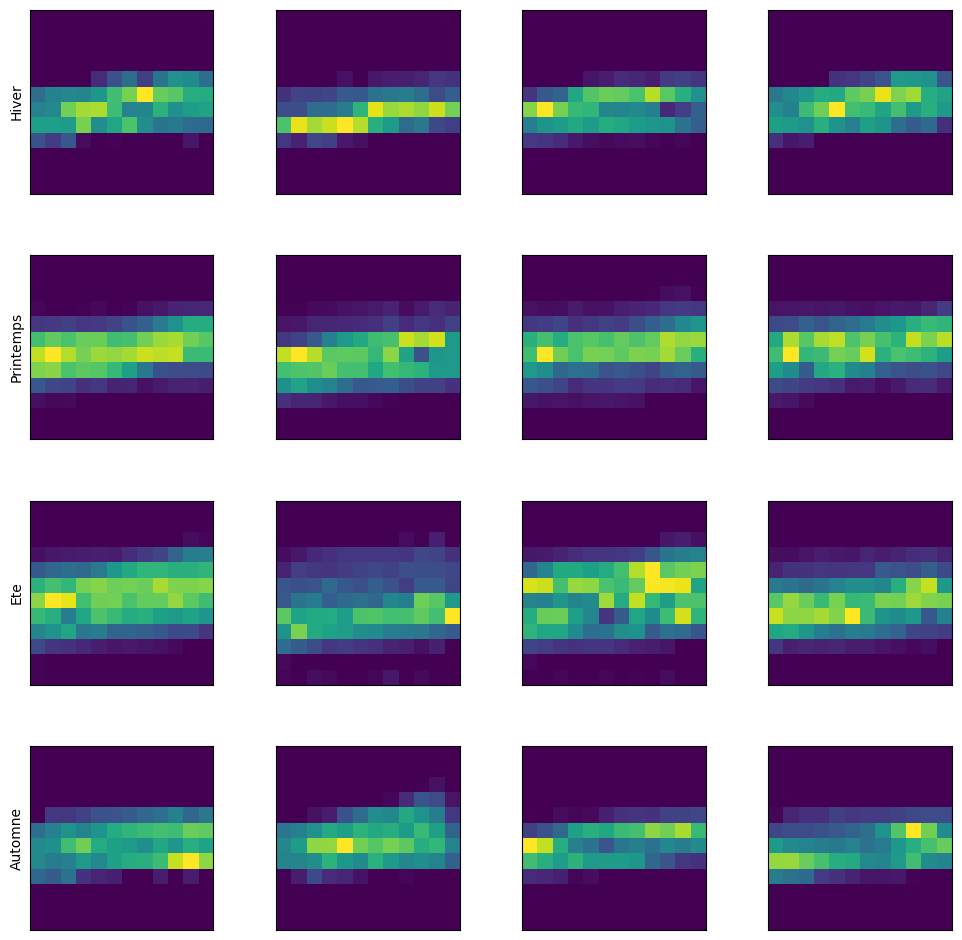

Epoch: 42 -- Generator Loss: 1.5573194026947021, Discriminator Loss: 0.8997288346290588

Took 43.21693181991577 seconds. 




100%|██████████| 1096/1096 [00:42<00:00, 25.81it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


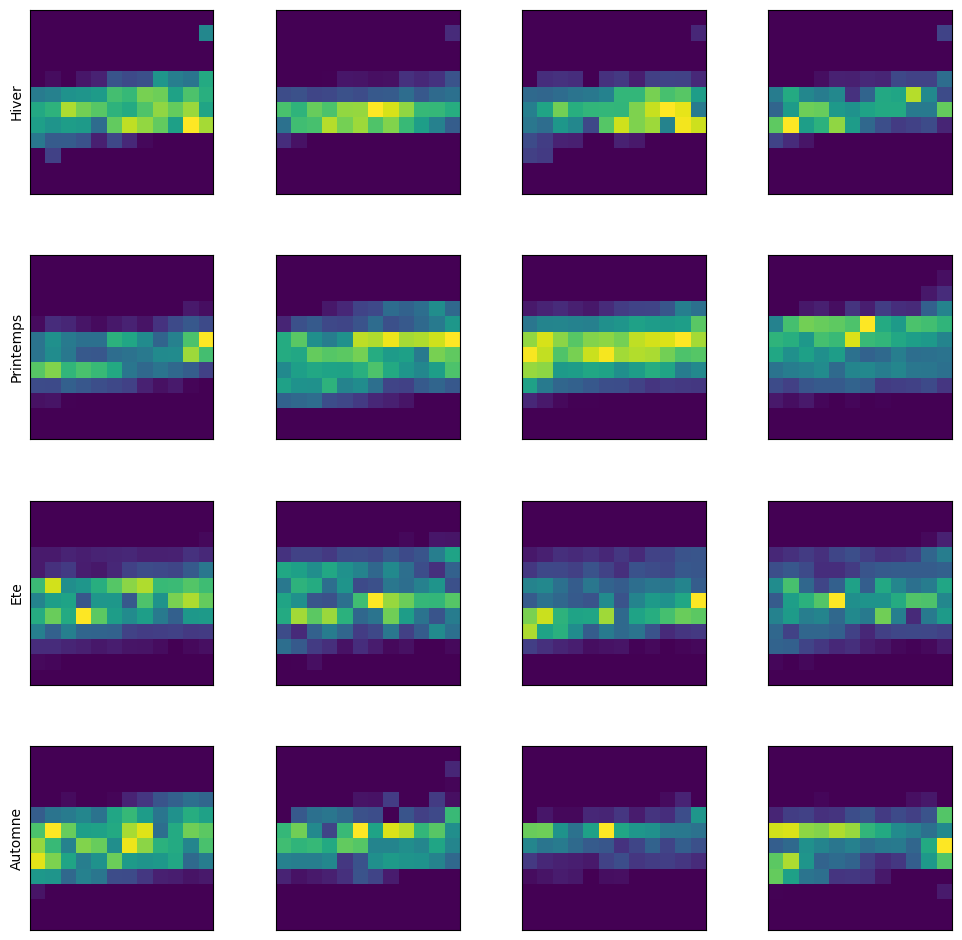

Epoch: 43 -- Generator Loss: 1.5810542106628418, Discriminator Loss: 0.881378710269928

Took 43.26220083236694 seconds. 




100%|██████████| 1096/1096 [00:42<00:00, 25.87it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


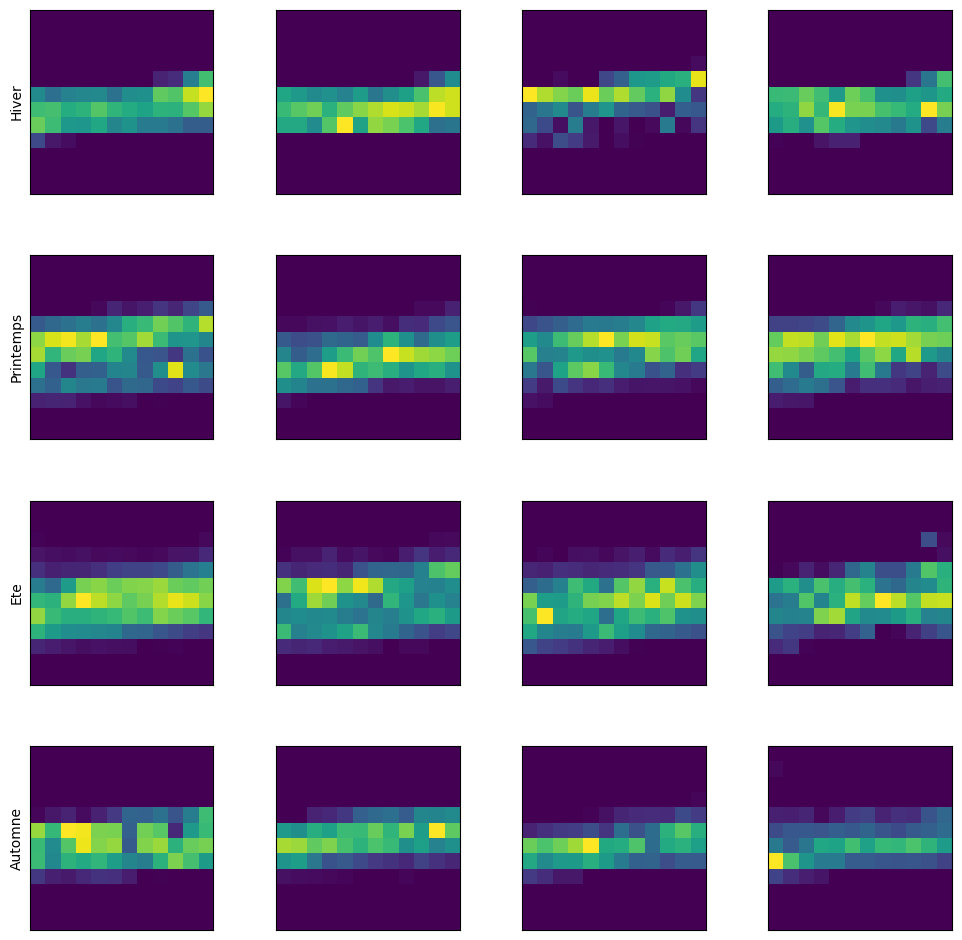

Epoch: 44 -- Generator Loss: 1.6435487270355225, Discriminator Loss: 0.8629150390625

Took 43.143632650375366 seconds. 




100%|██████████| 1096/1096 [00:43<00:00, 25.45it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


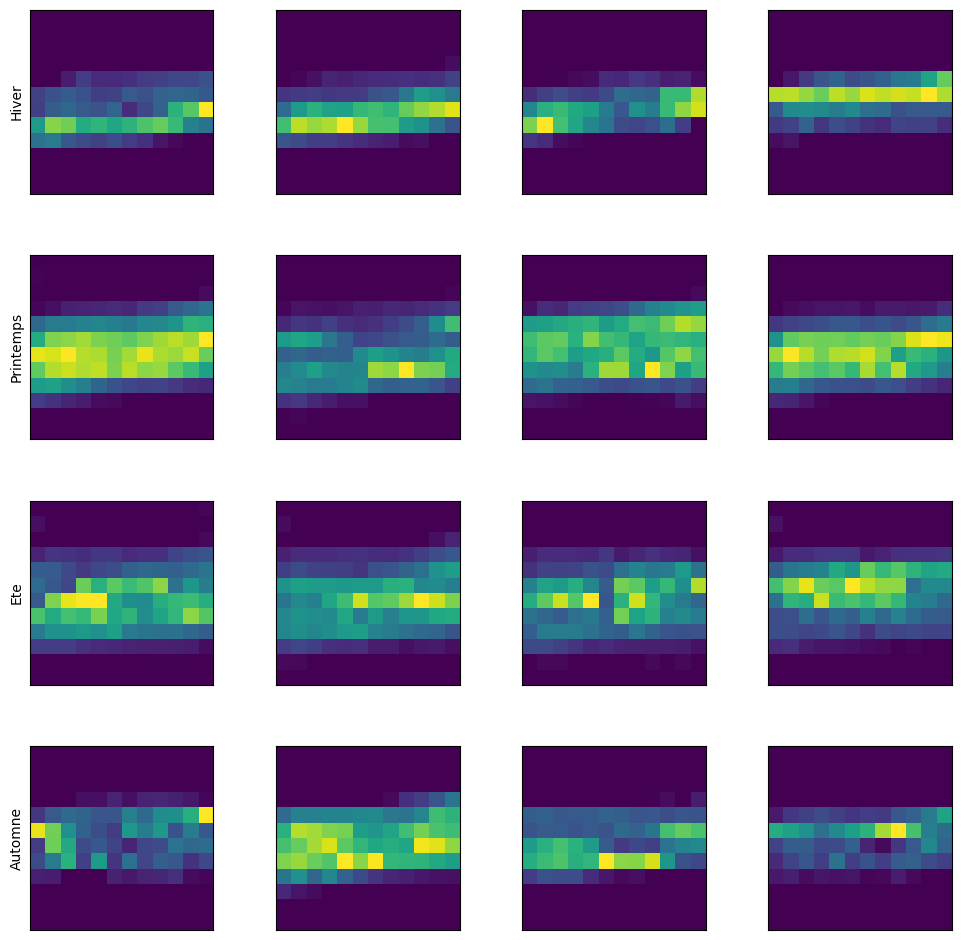

Epoch: 45 -- Generator Loss: 1.7199125289916992, Discriminator Loss: 0.8357210159301758

Took 43.86865043640137 seconds. 




100%|██████████| 1096/1096 [00:42<00:00, 25.92it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


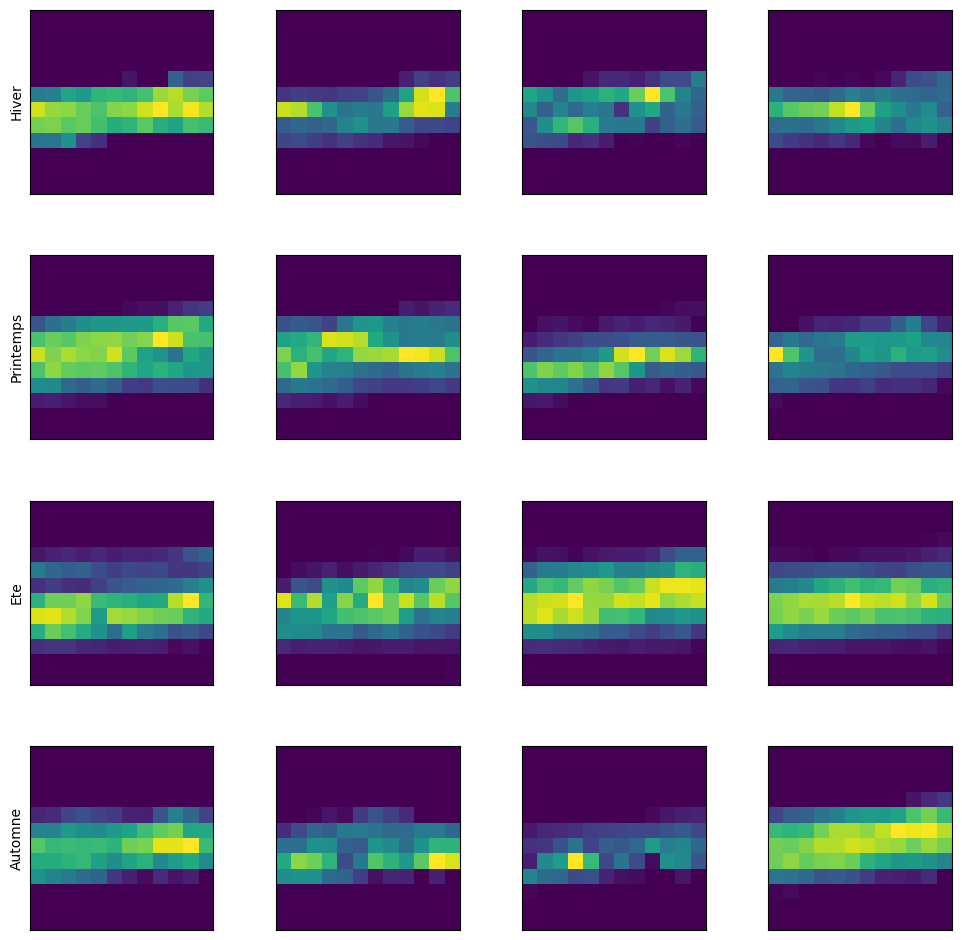

Epoch: 46 -- Generator Loss: 1.7115901708602905, Discriminator Loss: 0.848924994468689

Took 43.39263558387756 seconds. 




100%|██████████| 1096/1096 [00:43<00:00, 25.32it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


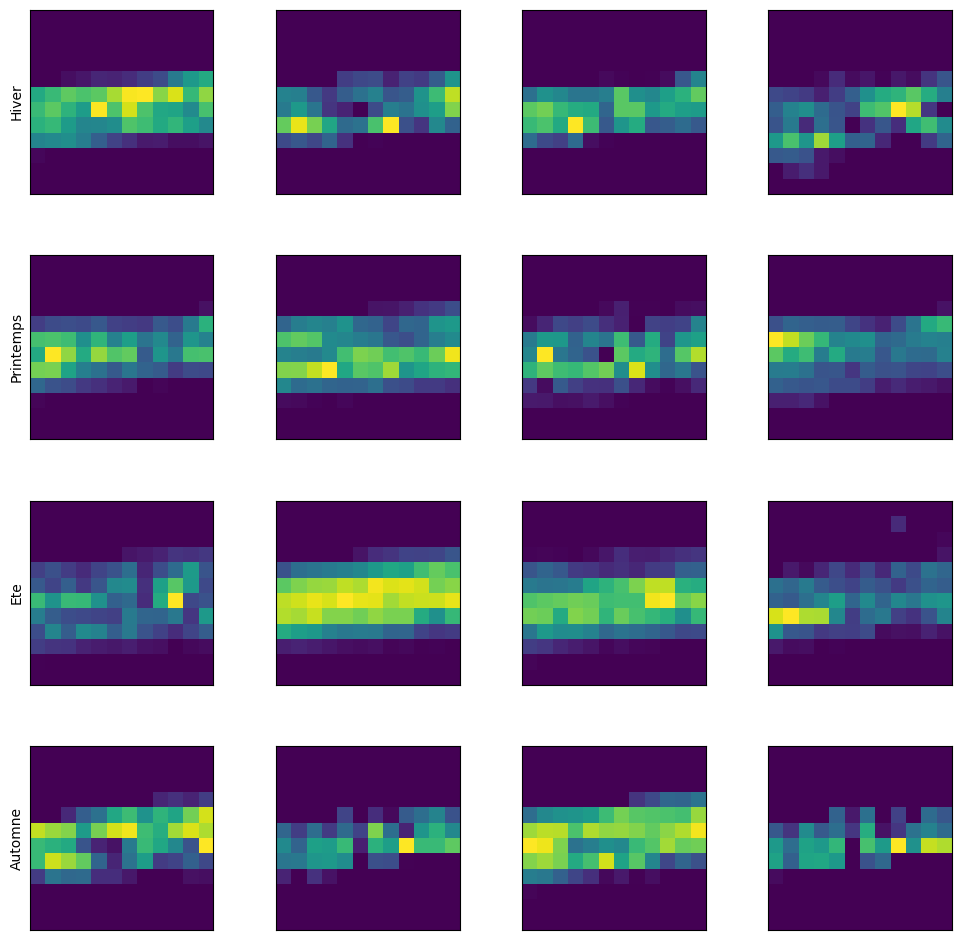

Epoch: 47 -- Generator Loss: 1.6793239116668701, Discriminator Loss: 0.8600214123725891

Took 44.12748050689697 seconds. 




100%|██████████| 1096/1096 [00:42<00:00, 25.66it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


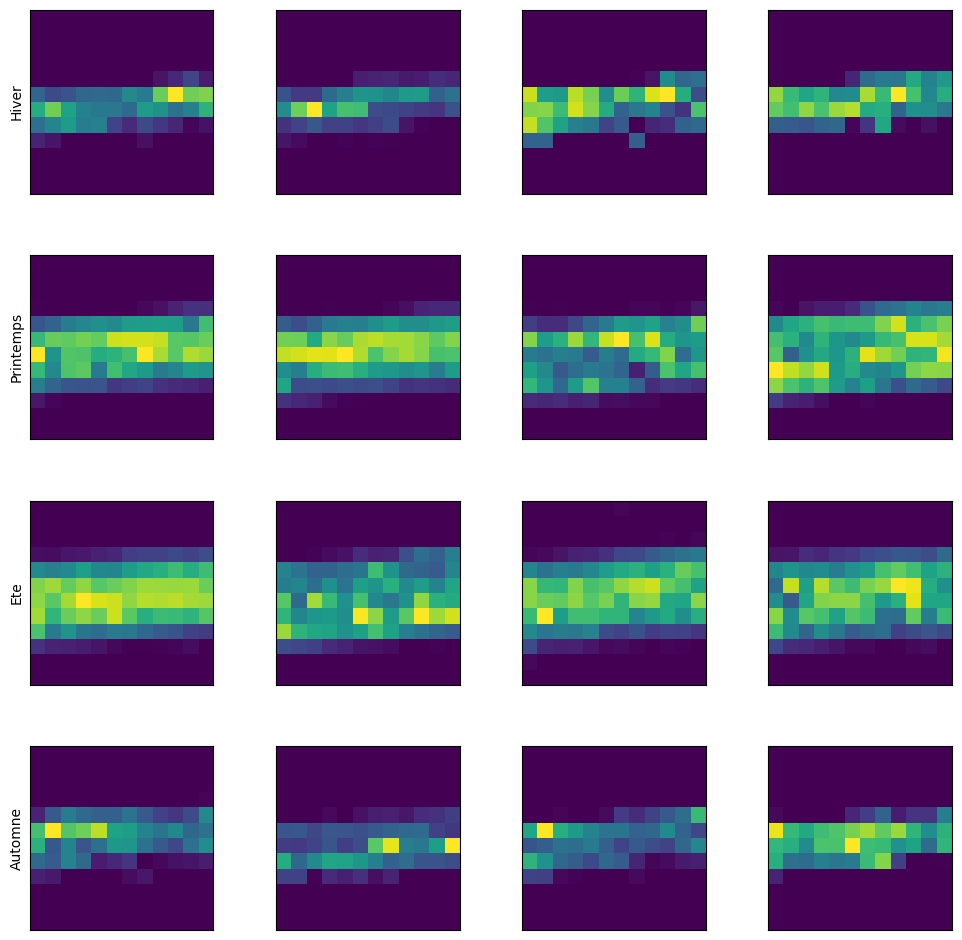

Epoch: 48 -- Generator Loss: 1.7539713382720947, Discriminator Loss: 0.8142842054367065

Took 43.58485150337219 seconds. 




100%|██████████| 1096/1096 [00:43<00:00, 25.35it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


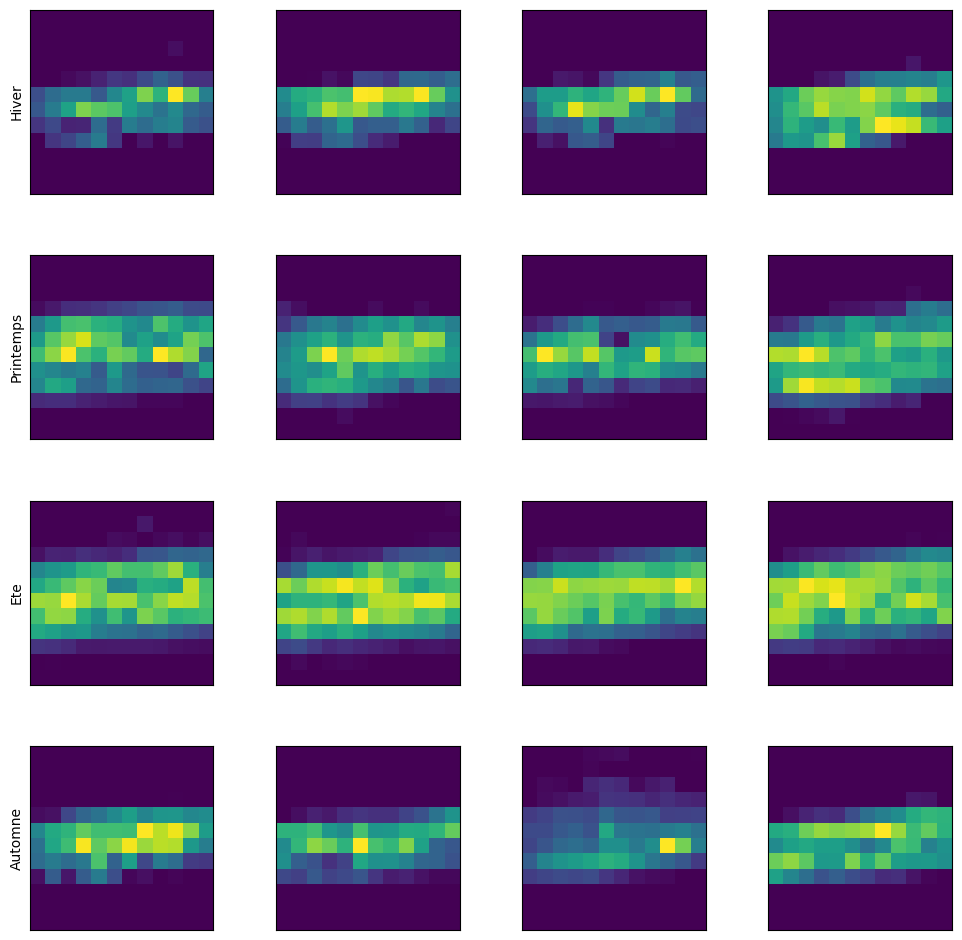

Epoch: 49 -- Generator Loss: 1.7586508989334106, Discriminator Loss: 0.8339536190032959

Took 44.05441856384277 seconds. 




In [22]:
def train(dataset, epochs=epoch_count):
  for epoch in range(epochs):
    d_loss_list = []
    g_loss_list = []
    q_loss_list = []

    start = time.time()

    itern = 0
    for image_batch in tqdm(dataset):
      d_loss, g_loss = train_step(image_batch)
      d_loss_list.append(d_loss)
      g_loss_list.append(g_loss)
      itern+=1
    show_samples(4, n_class, g_model) 

    print(f"Epoch: {epoch} -- Generator Loss: {np.mean(g_loss_list)}, Discriminator Loss: {np.mean(d_loss_list)}\n")
    print(f"Took {time.time()-start} seconds. \n\n")


train(dataset, epochs=epoch_count)

In [23]:
g_model.save("best_conditional_gan.h5")

In [6]:
# Fonction pour générer les données avec le modèle CGAN
def generator(noise_size, label):
    # Chargez le modèle
    model = load_model("best_conditional_gan.h5")
    noise_random = tf.random.normal(shape=(noise_size, 100))
    label_input = tf.ones(shape=(noise_size))*label

    gen = model.predict([noise_random, label_input])
    gen = gen.reshape(-1,)
    return gen

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


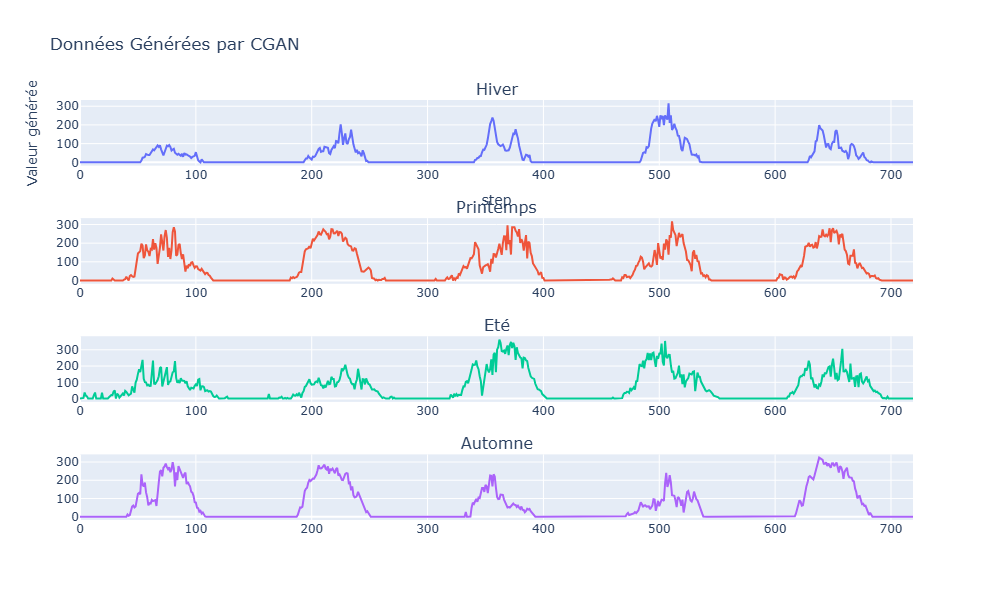

In [8]:
# Fonction pour générer les données avec le modèle CGAN
def generator(noise_size, label):
    # Chargez le modèle
    model = load_model("best_conditional_gan.h5")
    noise_random = tf.random.normal(shape=(noise_size, 100))
    label_input = tf.ones(shape=(noise_size))*label

    gen = model.predict([noise_random, label_input])
    gen = gen.reshape(-1,)
    return gen
def generate_plot(labels, noises_size):
    fig = make_subplots(rows=4, cols=1, subplot_titles=("Hiver", "Printemps", "Eté", "Automne"))
    for i in range(len(labels)):
        fig.append_trace(go.Scatter(y=generator(noises_size[i], labels[i])*382.0, mode="lines", showlegend=False), row=i+1, col=1)
    fig.update_layout(
        title="Données Générées par CGAN",
        xaxis_title="step",
        yaxis_title="Valeur générée",
        height=600, 
        width=600)
    fig.show()

generate_plot([0, 1, 2, 3], [5, 5, 5, 5])